# Inspiring Confidence and Easing Insecurity in the Pre-election period:

The Effect of Recruiting Military Veterans on Confidence in 2024 US Elections

Isaiah Espinoza (University of Maryland)

I report results from a recent survey experiment administered to test whether publicized efforts to recruit veterans to work as election staff and volunteers would improve public trust in elections and ease election insecurity. Results of the survey experiment support the notion that emphasizing veterans as the target of election worker recruitment efforts eases pre-election insecurity. Expectations of electoral fraud and concerns for voter safety were lower among those who read an announcement that veterans are being recruited to work as election staff and volunteers compared to those who read a control vignette where veterans were not mentioned. Notable is that there was a significant difference in confidence among those in the treatment condition who believe that results of the 2020 election were illegitimate. In addition, concerns over voter safety and potential for violence were lower among those who received the treatment.

In [ ]:
set.seed(1234)

# load packages
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'ordinal'

The following object is masked from 'package:dplyr':

    slice

# Attaching packages: easystats 0.7.4
✔ bayestestR  0.16.1   ✔ correlation 0.8.7 
✔ datawizard  1.1.0    ✔ effectsize  1.0.1 
✔ insight     1.3.1    ✔ modelbased  0.11.2
✔ performance 0.14.0   ✔ parameters  0.26.0
✔ report      0.6.1    ✔ see         0.11.0

In [ ]:
# custom function used to create Likert Plots

# To avoid excessive copy/paste, I made a function to create Likert plots
# it is mostly a wrapper around `ggstats::gglikert`, but with a specific set up
# particular colors, theme, etc. 
likert_plot <- function(data, x, ...,  
                        symmetric = FALSE,
                        variable_labels = NULL,
                        label_size = 2.5,
                        vline = FALSE,
                        title = waiver(), 
                        subtitle = waiver(),
                        caption = waiver(),
                        xlab = waiver()){
  
  p <- ggstats::gglikert(
    data = data, include = {{ x }}, ...,
    variable_labels = variable_labels,
    symmetric = symmetric)+
    
    # customize color
    ggplot2::scale_fill_grey(start = 0.5, end = 0.1)+
    # custom theme
    theme_bw(base_family = "TeX Gyre Pagella")+
    theme(
      legend.position = 'bottom',  # place legend on bottom
      axis.title.y.left = element_blank(), # blank out y-axis label
      axis.text.x = element_blank(), # remove percentage text along x-axis
      strip.text.y.right = element_text(angle = 0) # make facet label horizontal
        )
    
    if (vline==TRUE) {
    p <- p + geom_vline(xintercept = 0, color = 'black', linewidth = 1.2)
  } else {
      p
  }
  
 
  p <- p + ggplot2::labs(..., title = title, subtitle=subtitle, caption=caption, x = xlab)
  p

}

In [ ]:
# function for creating barplots
custom_barplot <- function(data, x, group, title = NULL, subtitle = NULL,
                           caption = NULL, legend_fill = NULL,
                           xlab = NULL){
  b <- data |> 
    group_by({{ group }}, {{ x }}) |> 
    count() |> 
    drop_na() |> 
    group_by({{ group }}) |> 
  mutate(prop = round(n/sum(n), digits = 3),
         pct = prop*100,
         res = str_c(pct,'% (', n, ')', sep = "")) |> 
  ggplot(aes(x = {{ x }}, y = pct, fill = {{ group }}))+
  geom_bar(position = 'dodge', stat = 'identity')+
  geom_text(aes(label = res), position = position_dodge(1.0), size = 2.5, vjust = -0.7)+
  scale_fill_grey(start = 0.5, end = 0.1)
  
  b <- b + ggplot2::labs(
    title = title,
    subtitle = subtitle,
    caption = stringr::str_wrap(caption, width = 99),
    fill = legend_fill,
    y = "Percentage",
    x = stringr::str_wrap(xlab, width = 85))
  b
}

In [ ]:
# custom function to return a certain selection of logistic regression model
# goodness-of-fit statistics
lrm.gof.stats <- function(model, ...){
  
  out <- data.frame(
    nobs = stats::nobs(model),
    null.deviance = model$null.deviance,
    df.null = model$df.null,
    logLik = as.numeric(stats::logLik(model)),
    deviance = stats::deviance(model),
    df.residual = stats::df.residual(model),
    chisq = as.numeric(model$null.deviance - stats::deviance(model)),
    df = as.numeric(model$df.null - stats::df.residual(model)),
    'P(>chi)' = pchisq(q=model$null.deviance - stats::deviance(model),
                       df = model$df.null - stats::df.residual(model), 
                       lower.tail = F)
  )
  out <- dplyr::as_tibble(out) |>  
  # rename column variables
  dplyr::rename(
    "Num.Obs."      = "nobs",
    "Log.Lik"       = "logLik",
    "Deviance"      = "deviance",
    "Deviance Null" = "null.deviance",
    "DF"            = "df",
    "chisq"          = "chisq",
    "P(>chisq)"     = "P..chi."
  )
  return(out)
}

In [ ]:
# see here: https://vincentarelbundock.github.io/tinytable/vignettes/theme.html#user-written-themes

theme_mitex <- function(x, ...) {
    fn <- function(table) {
        if (isTRUE(table@output == "typst")) {
          table@table_string <- gsub(
            "\\$(.*?)\\$",
            "#mitex(`\\1`)",
            table@table_string)
        }
        return(table)
    }
    x <- style_tt(x, finalize = fn)
    return(x)
}



## Introduction

Election administration officials make efforts to sustain public trust and confidence in the fairness and accuracy of elections, and attempt to boost such confidence where it may be deprived. Concerns for safety have developed among election staff and voters in more recent elections. Regular measures are taken to enhance the *trustworthiness* of the electoral process through practices meant to improve the conduct, transparency, or overall administration of elections in the United States.

Although election officials undertake great efforts to enhance the *trustworthiness* of election administration, public *trust*[1] in elections is a psychological construct influenced by many things outside of election official control such as partisanship or elite rhetoric \[@hooghe2018; @sances2015\]. Moreover, a person’s evaluation of the election in hindsight is often influenced by the election outcome itself \[@daniller2019; @stewart2022\]. Thus, measures taken by election officials can be undermined, trivialized, or made irrelevant depending on how one feels after the election results have come out.

Such volatile attitudes and evaluations post-election can leave a lasting impression that election officials must contend with upon the next election cycle \[@levendusky2024; @bowler2024\]. For instance, we have witnessed many people’s outright refusal to accept the 2020 U.S. election results as legitimate despite consistent review of the evidence confirming the results as fair and accurate. Such a case demonstrates that public trust in elections is, at best, only partial to trustworthiness of election administration in the United States.

One point of contention that election officials have faced in the past regard evaluation of election workers. Previous literature has focused on how voter interaction with election workers \[@claassen2008\], voting technology \[@herrnson2009\], and the voter experience generally \[@atkeson2007\], influences evaluations of election administration. As such, election worker competency has been examined as a factor significant to evaluations of performance of elections \[@hall2007; @hall2009\]. However, considering that individual perceptions and preconceived notions play a huge role in cognition \[@cikara2014; @vanbavel2021\], it is reasonable to expect that the group an election worker hails from would be an important influence upon the voter’s evaluation of the electoral process.

Supposing such is the case, we can expect that information about *who* (i.e., which groups) election officials are targeting in publicized recruitment efforts would lessen particular election insecurity, and concurrently, boost confidence. That is to say, it is reasonable to expect that telling people *who* will be working and volunteering as election staff would ease election insecurity, and therefore improve confidence that the election will be conducted fairly, accurately, and safe for all involved.

I report results from a recent survey experiment administered to test whether publicized efforts to recruit veterans to work as election staff and volunteers would improve public trust in elections and ease election insecurity. Results of the survey experiment show that emphasizing veterans as the target of election worker recruitment efforts is associated with greater confidence in elections and lower pre-election insecurity. Expectations of electoral fraud and concerns for voter safety were lower among those who read an announcement that veterans are being recruited to work as election staff and volunteers compared to those who read a control vignette where veterans were not mentioned[2]. Notable is that there was a significant difference in confidence among those in the treatment condition who believe that results of the 2020 election were illegitimate. In addition, concerns over voter safety and potential for violence were lower among those who received the treatment.

This paper is structured as follows. First, I provide a brief background on public trust in election administration. I synthesize a review of relevant literature with a focus on how political and social science has conceptualized and ascertained public trust in elections. Next, I supply reasoning for why military veterans are singled out as the relevant subset of the population expected to influence confidence in elections. I provide testable hypotheses of the study before moving on to describe the design of the survey, the measurement instruments therein, and the conceptual and operational definitions of the variables of interest. I explain my reasoning and method for constructing the primary dependent variable, which I broadly refer to as *confidence in elections*. I close by offering my interpretation of the results and suggest potential avenues for future inquiry.

## Background: Election Administration and Public Confidence

Election officials have tried hard to inspire confidence in the administration and conduct of elections by improving the degree to which elections are trustworthy. Development and implementation of procedures such as post-election auditing of ballots and logic-and-accuracy testing of ballot tabulation equipment are prominent examples adding to the long history of efforts to enhance the trustworthiness of election administration in the United States.

Prior to the year 2000, one of the main issues facing election administration was recruiting enough election workers to volunteer at the polls (i.e., poll workers) \[@maidenberg1996\]. Election worker recruitment is still much of an issue in the current era as it was then, perhaps worse \[@ferrer2024\]. In addition to ensuring election offices were adequately staffed, the controversy of the 2000 general election made the public more attentive to issues concerning the conduct and administration of elections. In particular, voting technology \[@herrnson2009\] and election worker competence was of interest in election studies \[@claassen2008; @hall2009; @hall2007\]. Following the passage of the Help America Vote Act in 2002, election officials efforts to boost public confidence in the conduct and administration of elections revolved primarily around the accuracy of vote counts, ballot tabulation equipment or voting machines, the commitment of election staff, and more \[@atkeson2007\].

In 2024, election officials made valiant efforts to boost public confidence elections within an intensified political climate that appeared quite hostile to election officials \[@edlin2024; @brennancenterforjustice2024\]. Although polling around the time indicated that most people thought that U.S. elections would be run at least somewhat well \[@nadeem2024\], many election officials nationwide took efforts to assuage the worry of those most skeptical.

Election anxiety was high in the lead up to the 2024 elections in the United States. Concerns for voter safety and the prospect of political violence remained prescient and compelled many local officials to prepare for the worst \[@edlin2024; @doubek2024\]. Election officials in Washoe County, Nevada, installed panic buttons for election staff that would alert a monitoring center to summon law enforcement \[@lincoln2024\]. Nevada also passed a law making it a felony to harass, threaten, or intimidate election workers \[@nevadasecretaryofstate2023\]. Leading up to election day, news outlets reported that election work had become a seemingly dangerous job \[@wire2024\]. A Brennan Center survey report stated that, “…large numbers of election officials report having experienced threats, abuse, or harassment for doing their jobs” \[@edlin2024\]. Concerns over the fairness of elections and accuracy of vote counts intensified, heightening concerns over the prospect of political violence and, in turn, increased worry for the safety of voters and election workers alike. Since election worker performance is significant to public evaluation of elections, added safety concerns that drive out election staff and repel volunteers can only detract from trustworthiness of the institution.

## Literature Reivew

Assessing the public’s *trust* in elections has not been straightforward. Inquiry into public trust in elections has been approached by scholars of political science in many different ways \[@cook2005\], often distinguishable by the scope of the research question and more or less constrained by the particular conception of public trust. Quite often, trust in election administration is conflated with trust in government writ large, government legitimacy, government or system responsiveness, or even satisfaction with democracy \[@daniller2019\]. At this level, not only is the level of public trust in elections sometimes vague, but there’s little consideration over the difference between such attitudes pre-election and post-election. In contrast, a considerable amount of research tends to conceive of public trust in accordance with the institution in question \[@atkeson2007; @hooghe2018\].

Election administration[3] is just one part of the larger set of institutions which form the electoral system. As such, the performance of the institution along with the rest “…lends credibility to the outcome of an election: whether it is considered by citizens and the international community to be fair and legitimate.” \[@stewart2022, 236\].

Trust in the conduct of elections concerns aspects of elections that fall squarely within the institution of election administration. At this level, for instance, public trust in elections is ascertained by capturing assessments about the perceived accuracy of vote counts (e.g., whether votes are/were counted as intended).

Intuitively, enhancing public trust in elections would best be accomplished by enhancing the *trustworthiness* of the institution, e.g., enhancing vote tabulation equipment and technology, conducting audits. However, trust and confidence in elections has become ever more precarious over the last few election cycles. Especially considering public polling data since 2000 shows that confidence that votes were, or would be, counted as intended was in a consistent decline despite efforts towards bolstering election integrity and trustworthiness \[@sances2015\]. This is even more pronounced considering the role that partisanship has had on such confidence over accuracy of vote counts \[@sances2015; @stewart2022\].

There’s also stark difference in public trust before the election has occurred compared to after, a phenomenon referred to as the “winner-loser gap”; the “winners” are those who supported the winning candidate and the “losers” are those who supported the losing candidate. Much research has been dedicated to analyzing the sentiment of electoral winners vs losers, and vice versa \[@nadeau1993; @daniller2019\]. Opinions of electoral trust gathered after the election has occurred, however, are limited considering the well-recognized impact that the electoral outcome itself has on feelings of public trust in elections \[@daniller2019\].

As such, it is questionable whether we can characterize public trust in the pre-election period as the same trust after the election results have come out. The former is *anticipatory*—i.e., the kind that is more or less anxious given the uncertainties surrounding the election. The latter is *empirical*—a judgement discerned in hindsight after the experience of the election event has occurred. As discussed by @stewart2022, not only was confidence in vote count accuracy influenced by the voter experience, but so too were evaluations of election officials \[-@stewart2022, 242-243\]. Not to mention the influence that the election results would also have on such evaluations. In other words, evaluations of trust considered in hindsight are influenced by the voter experience and the outcome of the election results. This study, in contrast, focuses primarily on that *anticipatory* kind of confidence, which speaks more to those insecurities based on perceptions of the institution’s trustworthiness than upon the particular voter experience.

Regardless of the measures taken by election officials to boost public confidence in the *trustworthiness* of election administration (e.g., conducting audits, testing election machines), public *trust* and confidence in elections more generally is apt to shift dramatically post-election based on factors such as partisanship, elite rhetoric, particular state policies, and more \[@nadeau1993; @carter2024; @coll2024a\]. Comparable research finds that confidence in elections is increased through elite rhetoric from fellow partisans affirming legitimacy of elections \[@clayton2023\], or through the provision of information about the electoral process or other official messaging of election officials themselves \[@gaudette2025\]. Moreover, prior research has found that evaluation of election workers themselves are an important factor when it comes to levels of public confidence in the electoral process \[@hall2007; @hall2009; @claassen2008\]. Such studies focused on the quality of the voter experience with reference to the interaction between voter and election worker.

Beyond the general competence of election workers, however, the quality of the voter experience may be influenced merely by prior impressions about *who* comprises election staff and volunteers. Political and other social science researchers have recognized for some time the power that group identity can have over attitudes and perception \[@xiao2016; @xiao2012; @vanbavel2021\]. As such, we can expect that information identifying the particular groups being recruited to serve as election staff will be enough to improve confidence in elections, and lessen expectations of electoral fraud. The next section elaborates on the proposed theory and why military veterans are of particular interest in this regard.

## Theory: Why Veterans

The theory tested in this study is this: when the public is informed that election officials are actively recruiting veteran military service members to work at election sites as staff or volunteers, their overall confidence in the fairness, accuracy, and integrity of the electoral process will improve. Said another way, insecurities over the integrity of elections administration and safety of voters lessen as the public learns that military service veterans are being sought out by election officials to staff or volunteer at election sites. The stimulating influence of veterans as a group in the abstract is expected to counteract distrust and insecurity pertaining to the institution of elections administration, as well as inspire greater trust in the same. This prompts an obvious question: why would information about efforts to recruit veterans to work as election staff and volunteers have any influence on confidence in elections?

Election officials don’t focus on recruiting people of a particular demographic, status, class, or prestige in order to shore up public trust in elections, and they don’t discriminate recruitment efforts based on who the public thinks is best suited to secure elections from fraud. Election officials are likely to be agnostic as to who dedicates their time to civil service such as election work. Especially since staffing has been an issue since at least the 1990s \[@maidenberg1996; @ferrer2024\]. In 2020, such efforts were made far more difficult by the COVID-19 pandemic \[@mena2020; @abbate2020a\]. There’s no special reason to target veterans for recruitment above other groups. Indeed, there’s no reason to discriminate recruitment efforts at all if the point is purely to fill staffing vacancies.

There was a sudden push to target veterans for recruitment efforts that arose shortly after the events on Capitol Hill on January 6th, 2021. After the 2020 election, large efforts were made to recruit military veterans and their families to work or volunteer as election staff \[@wetheveterans2022; @nflfootballoperations2022\]. Prior to that point, young people were sometimes given special mention as targets of election worker recruitment efforts \[@powerthepolls2020; @herndon2020\]. Generally, however, recruitment efforts cast a wide net, indiscriminate of who applies \[@ross2020; @conde2020\].

One can speculate that the motivation to associate military veterans with civic engagement and democracy may be intended to counter negative perceptions and impressions given by the proportion of veteran service members arrested for taking part in the events on January 6th \[@milton2021; @loewenson2023; @jensen2022a\]. Especially with regard to research demonstrating that willingness to support violent efforts to overturn election results (in support of Trump) is, on average, more common among veterans than among matched samples of non-veterans \[@pape2024\]. This is in addition to a strengthened association portrayed in media outlets between military veterans and militias \[@steinhauer2020\]. Prior research has substantiated such a connection between veterans and militia groups. @cooter2024 notes from her 3-year ethnographic fieldwork among Michigan militia members that, “…approximately 40% of militia leaders and 30% of members had previous military experience. Most of these veterans actively sought out such groups, as opposed to being recruited by them” \[see also @cooter2013\]. Thus, countering such associations by promoting a different image of veterans to the mass public and veterans alike seems like a reasonable motivation. Yet such speculation is just that.

The claim that recruiting veterans to work as election staff and volunteers would improve public confidence in elections emerges as non-profit organizations—mainly comprised of veteran and military family members themselves—operate under, and promote, that assumption \[@looker2024; @lawrence2024; @wentling2024\]. Non-profit groups of late have made incredible strides in targeted recruitment efforts under the notion that veterans are uniquely capable, committed, and best fit to serve the needs of the United States as civil servants and volunteers at election sites. Indeed, this study can be seen as a test of a particular assumption that veterans have about themselves—the assumption that their mere presence and civic engagement will inspire confidence in elections among the public.

Veterans are, after all, civilians. Civilians with shared (but varied) experience and status of prior military service, but who are no more or less qualified for this civil service[4] over non-veteran civilians. To be frank, announcements about concerted efforts to recruit veterans as election workers should not reasonably influence one’s trust that votes will be counted more accurately, or that election fraud will not occur; there is no known evidence demonstrating that actually employing veterans as election staff or volunteers further improves the safety, security, and overall integrity of elections in the United States. Moreover, there’s no known evidence of positive influence on public perceptions of said outcomes when voters encounter military veterans working as staff or volunteers at elections sites. So, why veterans?

Two considerations underpin the notion that information about veterans will improve trust and quell distrust in elections. First, positive public regard for veterans *in general* is sufficient to elicit greater trust and lower distrust in elections despite the fact that information about veterans as election workers, or even merely information on efforts to recruit veterans, has no bearing on the actual integrity of the electoral process.

An underlying assumption here is that there *is* something special about veterans in the eyes of the public generally, but this doesn’t include a proposition on exactly *what* that special something might be in theory. This is partly due to there being limited research on public opinion about former and active military service members distinguished separately from public opinion about the military as an institution in general. Support for the military is generally pretty high, but attitudes about the military in general can’t be construed as public opinion about veterans as a group. The evidence that can be gathered concerning public regard for military veterans shows that, generally, veterans are perceived favorably among the general public and all groups express exaggerated support for veterans in more than one way \[@kleykamp2018\], suggesting that public regard for veterans is prescribed by widespread social norm. Although military recruitment shows a downward trend as of late, public perceptions of veterans are overwhelmingly positive \[@kleykamp2023\].

Beyond such findings, it is overtly clear that former and active military service members are highly revered nationwide. Veteran’s day is a national holiday, and custom prescribes thanking military members for their service. Calls to “support the troops” are distinct from calls to support the politics the troops are deployed to pursue. In 2016, former NFL player Colin Kaepernick went from sitting to kneeling in protest during the playing of the National Anthem upon criticism that sitting in protest implied disrespect for active and former military service members \[@haerens2018\].

Generally high public regard for veterans is taken together with literature suggesting that public trust in elections is malleable to factors that range in logical relevance to the actual structure or administration of elections. On the one hand, public trust is, indeed, influenced by information specifically about the processes of conducting elections \[@gaudette2025\]. On the other hand, the public’s trust in elections is not beholden to the demonstrated *trustworthiness* of the institution of election administration. Whether generally high public reverence for veterans is due to injunctive social norms or not, what may be posited is simply that positive regard for veterans in general may function sufficiently as a cue to elicit greater trust in elections despite relevance.

Second, veterans are a particularly potent group where mention of one’s veteran status seems to have a calming effect on attitudes. More so than just the general positive favor afforded to veterans, the group appears to have a somewhat pacifying effect on negative or otherwise contemptible discrimination, prejudice, and social stigma. For instance, recent research shows that, during his campaign in the 2020 Democratic Primaries, Pete Buttigieg’s military background mitigated discrimination against him when he was presented as a veteran married to a man \[@magni2024\]. Similar research has also found that a candidate’s veteran status affords them better evaluations regarding competency in particular issue areas (e.g., war competence) \[@teigen2013; @hardy2019\]. Moreover, veteran status seems to mitigate or nullify usual stigmas associated with mental illness. That is to say, there is negative stigma associated with mental illness \[@corrigan2002\] and such stigma incurs labor market discrimination \[@hipes2016\], but evidence suggests that veteran status overrides such stigma and discrimination \[@maclean2014\]. Or, in another light, mental illness is seemingly more *understandable* (i.e., permissible) for veterans given the presumptive reasons for their mental strife. And media framing as such plays an important role on public perception \[@kleykamp2015\]. Relatedly, attitudes about homelessness and PTSD—ranging from perceived causes of homelessness, whether the federal government should dedicate more resources, perceived effectiveness of policies, to compassion for homeless individuals—are generally more favorable for the homeless population among veterans than for the homeless population of general adults \[@tsai2021\].

Such effects primarily pertain to attitudes about individual people or groups (e.g., a political candidate, prospective employees, the homeless population). The capacity of one’s veteran status to pacify prejudice, discrimination, and stigma likely extends out to veterans as a group in a similar fashion. Information that election sites will be staffed by veterans may be enough to ease insecurities about the competence and commitment of the institution to conduct fair and accurate elections.

## Trust and Distrust in Elections

This theory is constrained to public confidence in the administration of elections in the United States. To be clear, the scope conditions in which this theory applies concern public trust and distrust in election administration in the anticipatory period prior to the election event. The theoretical relationship between trust and distrust is important to understand, especially when it comes to the dependent outcome of interest. Before going further, it is necessary to explicate the conception *confidence in elections* with respect to how I’ve defined trust and distrust in elections.

Trust is, after all, merely *belief* held in the face of uncertainty. Trust is reliance on the veracity of belief in the face of uncertainty. Said another way, trust is *assured belief* dependent on its supposed veracity; a state of certainty with respect to some belief or judgement. It is “*assured*” because it is one’s belief that relies on something rather than nothing. Hence quantitative methods of the sciences are replete with things such as *confidence* intervals around our estimates. Therefore, I understand trust to refer to the state or quality of certainty around one’s beliefs or expectations; the extent to which one is assured of their expectations regarding what is or what will be the case.

The kind of *trust in elections* I refer to concerns the expectations drawn up from one’s judgement about the functioning of the electoral process—the extent to which one is assured in the belief that the electoral process will be fairly and accurately administered. I follow the notion of public trust in elections explicated by @stewart2022,

> “Public trust in U.S. election institutions comes down to whether voting machines accurately record votes, voter registration systems accurately record those eligible to vote, geographic information systems accurately assign voters to voting districts, election-night reporting systems accurately aggregate and communicate election results to officials and the public, and postelection audit and canvassing procedures proceed impartially and in accordance with the law.” \[-@stewart2022, 236\]

That being said, I also account for expectations of electoral fraud, which I refer to as *distrust* in elections distinguished from trust. Distrust in this sense is also a belief, an expectation, about the anticipated functioning of the process. Note, however, that the prefix *dis-* in distrust implies “apart”, “lack of, not” or “opposite”. Conventionally, distrust is defined simply as the absence of trust, thus denoting a simple inverse and mutually exclusive relationship. However, as it concerns the psychology of an individual, *a lack of trust doesn’t necessarily imply opposite expectations or opposing beliefs*. In particular, a lack of trust that votes will be accurately recorded, etc., doesn’t necessarily imply inversely proportional expectations that electoral fraud will occur. In other words, although the relationship between trust and distrust is inverse, this relationship is not mutually exclusive.

A person who is certain that electoral fraud will occur clearly lacks trust in elections; an expectation that electoral fraud will occur necessarily implies a lack of trust in elections regardless of positive expressions of trust. However, the reverse isn’t also true; expressing a lack of trust in elections *doesn’t necessarily imply* an expectation that electoral fraud will occur. Rather, a lack of trust implies an absence of assurance in the belief that the process will be conducted fairly and accurately—a lacking quality of certainty around said belief. An absence of such assurance denotes a state of *insecurity*. Other sources of uncertainty may challenge a person’s confidence regarding the integrity of elections independent from anything that would lead them to believe electoral fraud will occur or has occurred. However my use of distrust refers to the assured belief that the outcome will be invalid—that outcomes will be independent of the process as prescribed, thus rendering outcomes as arbitrary. Specifically, distrust implies assurance in the belief that electoral fraud will occur.

As such, trust and distrust represent opposing degrees of confidence along the same spectrum. However, despite the inherent contrast, one can hold both positive degrees of trust and distrust, feeling relatively confident in both respects. Accordingly, *equivalent degrees of trust and distrust cancel out*, rendering one relatively more insecure about their expectations of the future despite the fact that they may report feeling confident in either direction respectively. When trust and distrust are considered reflective of one’s confidence about future expectations, then both can be placed along the same spectrum. Therefore, a lack of confidence denotes insecurity.

This means that a person’s baseline level of confidence in elections must take into account their present degree of distrust—i.e., their expectations of electoral fraud. Something may cause a person to have greater expectations that election fraud will occur, which in turn will always lower their trust in elections. In contrast, a person’s trust in the integrity of the electoral process is reduced by the extent to which they expect that electoral fraud will occur.

Thus, it follows that a person distrusts the integrity of the electoral process to the extent that they are to some extent certain that electoral fraud will occur or has occurred. They are, perhaps, poised to discount election results as invalid or illegitimate in advance. Either way, both trust and distrust refer to some positive degree of confidence (i.e., assurance) regarding one’s expectations. They are distinguished by reference to either the normative idea about what *should* come about, or what is *supposed* to come about given the logical structure and integrity of the process. If the structure and integrity of some process is coherent and secure, respectively, then the outcome that follows will be valid. Should the integrity of that process be damaged or opaque, then the process becomes vulnerable and validity of the results are open to challenge. With respect to the administration of U.S. elections, the confident voter expects that votes will be counted as voters intend, election staff will competently administer elections, election technology will be secure from nefarious tampering, and that the process will be fair for all involved.

## Hypotheses

The outcome of interest is *confidence in elections*, which refers to trust in elections—i.e., expectations that elections will be administered fairly and accurately—compensated by distrust in elections—i.e., expectations that electoral fraud will occur. Considering the generally positive perception afforded to veterans by the public, it is reasonable to suspect that efforts that promote recruitment of veteran military service members to work as election staff and volunteers would boost public *confidence in elections administration*. Indeed, that is the primary hypothesis of this study. Although citizens may vote in various ways across the country (e.g., by mail, ballot drop box, in-person), the simple announcement that election officials are engaging in efforts to recruit veterans to work as election staff may boost confidence in elections administration regardless of how, or whether, an individual plans to vote. Formally,

> H<sub>1</sub>: Announcements that election officials are recruiting miilitary service veterans to work as election staff and volunteers will be associated with greater confidence in elections administration compared to announcements that do not mention military veterans.

Asking participants whether they supported programs intent on recruiting anyone to work as election staff would garner support regardless of the target group. Considering that support and admiration for veterans is generally high among the population \[@kleykamp2023\], then discerning the impact on one’s confidence would require a survey experiment designed to determine whether publicized recruitment efforts targeting veterans as a group would have any special effect on confidence in elections administration.

In addition, prior research has shown that confidence that one’s own vote would be counted as intended has been much stronger than confidence that votes nationwide would be treated likewise \[@sances2015; @stewart2022\]. In other words, the public is more trusting of elections closer to home. Taking into account that confidence is lower for elections conducted outside of one’s local area, then information that veterans are being recruited to help conduct elections in locations beyond one’s locale may close this gap between confidence in elections within one’s local area and confidence in elections elsewhere. Although it may be difficult to discern whether recruiting veteran service members would improve confidence in elections near one’s local area in light of such hometown favoritism, a positive effect on confidence in elections held beyond one’s local area—where confidence is already expectedly lower—can help discern the impact of the group alone on public opinion. Therefore, any observed disparity of confidence in elections between those within one’s local area and those beyond will be smaller among those who are presented with information about election official recruitment efforts of veteran service members. Formally,

> H<sub>2</sub>: Differences in confidence in elections in one’s local area and confidence in elections in Maricopa County, AZ, will be smaller among those who are presented with an announcement that election officials are recruiting miilitary service veterans to work as election staff and volunteers compared to those presented with an announcement of recruitment efforts that do not mention military veterans.

Since the results and events following the 2020 election loomed large in anticipation of the U.S. 2024 general elections, it is reasonable to take into account beliefs about legitimacy of the 2020 election. This group who denies the legitimacy of the 2020 election results were possibly the most apprehensive (distrusting) of the 2024 election. However, given that veteran service members are held in high regard, generally speaking, announcing that veterans are being actively recruited to work as election staff and volunteers is expected to positively influence confidence in elections among those who remained firm in the belief that the 2020 election results were illegitimate. That is to say, despite their belief about the illegitimacy of the 2020 election results, I expect that informing them about veteran recruitment efforts to improve their confidence in elections. I take into account the relationship between partisanship and 2020 election legitimacy beliefs and include partisanship as a control in the analysis[5].

> H<sub>3</sub>: Among those who refute the legitimacy of the 2020 election results, those presented with an announcement that election officials are recruiting veteran service members for election jobs will be associated with greater levels of confidence in elections compared to those presented with an announcement of recruitment efforts that do not mention military veterans.

Prior research has found that political candidates benefit from having a military background \[@mcdermott2015\], especially evaluations of candidate’s prospective performance on particular war issues (e.g., foreign policy, terrorism) \[@hardy2019\]. The idea is that prior military service provides meaningful information to use as a heuristic in regard to such “war issues”. Although veterans are no longer actively serving, there’s potentially some lingering general assumptions about the capacities and motives of military veterans to provide safety and security arising from the nature of their prior occupation as members of the U.S. armed forces. Insofar as the physical safety of people at election sites is a “military matter”, then the potential that election sites may be staffed with military veterans may ease related concerns about the safety and security of those places. As such, I expect that concerns about potential for violence will be lower, and confidence in voter safety higher, when presented with information that veterans are being actively recruited to work and volunteer in election offices.

> H<sub>4a</sub>: Concerns about the potential for violence, threats of violence, or intimidation while voting in person will be lower among those presented with an announcement that election officials are recruiting veteran service members for election jobs compared to those presented with an announcement of recruitment efforts that do not mention military veterans.

> H<sub>4b</sub>: Confidence that voters will be safe to vote in-person at election sites will be higher among those presented with an announcement that election officials are recruiting veteran service members for election jobs compared to those presented with an announcement of recruitment efforts that do not mention military veterans.

## Experiment Design and Survey Measures

To test the theory that publicized efforts to recruit veterans to work as election staff and volunteers would improve confidence in elections and ease insecurity, a recent experiment was embedded in a survey developed and conducted by the Center for Democracy and Civic Engagement (CDCE) at the University of Maryland. The survey was fielded from August 29th, 2024 to September 18th, 2024 on a non-probability sample of 1,287 U.S. citizens 18 years of age or older. Respondents were randomly split into either the treatment ($n = 650$) control ($n = 637$) conditions[6].

The median age was $46$ (mean age was $47$), $51.13\%$ ($n = 658$) women, $46.46\%$ ($n = 598$) men, and approximately $1.24\%$ who identified as either Non-binary/third gender ($n = 7$) or preferred not to say ($n = 9$). The sample primarily identified as White or Caucasian $75.76\%$ ($n = 975$), while all other non-White respondents comprised $23.08\%$ ($n = 297$) of the sample. Those who held a graduate level degree (e.g., Master’s, Doctorate, or Professional level) comprised $12.9\%$ ($n = 166$) of the sample; those with either degree at the Associate or Bachelor’s level comprised $35.82\%$ ($n = 461$), while $21.99\%$ ($n = 283$) had some college but no degree; and $28.13\%$ ($n = 362$) had either a high school level or equivalent education or less than high school. The largest proportion of the sample were Democrat at $43.98\%$ ($n = 566$), followed by Republicans at $41.96\%$ ($n = 540$). The proportion of true Independents[7] was $12.59\%$ ($n = 162$). Among the sample, $34.11\%$ ($n = 439$) said they had an immediately family member who was currently serving or had previously served in the U.S. military; $64.72\%$ ($n = 833$) didn’t have a family member who served. Approximately $8.24\%$ ($n = 106$) of the sample were veterans, while $1.17\%$ ($n = 15$) reported to be actively serving.

Survey participants read either a treatment or control vignette, which resembled a news article about efforts in Maricopa County, AZ to recruit election staff and volunteers for the 2024 general election[8]. The treatment vignette referred to a program designed to recruit veterans and their family members and describes an interviewee “Jordan Braxton” as an Army veteran. The control vignette simply omitted any mention of veterans and their family members, and didn’t describe “Jordan Braxton” as an Army veteran. Beyond those small differences and the headlines, the article vignettes are identical. Therefore, effects can be attributed to the information about veterans in the treatment vignette[9].

A manipulation check is intended to ensure that the experimental treatment (or manipulation) is received by respondents as the researcher intends. Since this experiment required respondents to read a faux news article, inattention or speeding through vignette presentation would undermine results. To mitigate this as much as possible, the survey included two items as an attention check prior to presenting either the treatment or control vignette. Respondents who failed to select a certain response twice in a row were removed from the survey. Upon presentation of either the treatment or control vignette, survey respondents were unable to progress further in the survey until at least 15 seconds had elapsed.

It should be noted that Maricopa County, AZ was chosen as the setting of the story in the vignette due to the increased scrutiny levied toward election administration there after the 2020 election \[@giles2021; @maricopacountyelectionsdepartment2022\]. Because of this, treatment effects are potentially limited or constrained to attitudes concerning the location specified in the vignette. A block of survey items asked specifically about Maricopa County, AZ, followed by an identical block of items that asked the same questions about one’s local area. I compare and discuss results between the items pertaining to different settings.

Over the past two decades it became commonplace for national polls to gauge public confidence in election administration (i.e., voter confidence) by asking some variety of the question, “How confident are you that your vote \[will be/was\] counted as you intended in the most recent election?” \[@hall2009; @sances2015; @stewart2022\]. In addition, since 2008, the Survey of the Performance of American Elections (SPAE) has included a good number of relevant questions to more thoroughly assess trust and confidence in election administration. Such questions inquire into the voter experience with the institution more directly. This study borrows, modifies, or takes inspiration from certain question items found within the 2022 SPAE and other survey items from the Pew Research Center’s 2018 American Trends Panel wave 38 \[@dunn2018\].

The items in this study all inquire into confidence over one’s expectations in anticipation of upcoming elections. In addition, the survey of this study focused on attitudes regarding election workers such as election officials, staff, and volunteers specific to the location mentioned in the vignette—Maricopa County, AZ—as well as specific to one’s local area[10].

The survey included items that assessed both trust in elections administration and expectations of electoral fraud, referred to simply as *trust* and *distrust*, respectively. Responses from these two sets of items were utilized to construct the primary dependent variable, *confidence in elections*. Additionally, a pair of survey items assessed concerns for potential violence and confidence in voter safety. The pair was asked once in regard to Maricopa County, AZ and again with respect to one’s local area[11]. Although two survey items are insufficient to serve as a composite scale, safety concerns will be evaluated by examination of response to these two questions in particular.

Prior to the reading the treatment or control vignette, participants responded to distinct survey items assessing one’s beliefs about the legitimacy of the 2020 election results (“Regardless of whom you supported in the 2020 election, do you think Joe Biden’s election as president was legitimate, or was he not legitimately elected?”). Respondents selected either “Legitimate” or “Not Legitimate”.

The conventional multiple item assessment of partisanship was included and used to construct a variable of partisanship consisting of three categories: Democrat, Republican, and independent.

A set of five survey items measured public trust in elections by inquiring into the degree of confidence that votes will be counted as voters intend, confidence that electoral systems are secure from technological threats, perceived commitment of election staff, confidence that outcomes will be fair, and confidence that the voting process will be fair. Each item in this series presented four response options from “Not at all \[confident/committed\]”, “Not too \[confident/committed\]”, “Somewhat \[confident/committed\]”, and “Very \[confident/committed\]”. In total, five survey items measure different aspects of trust in elections administration.

[1] I adopt a distinction made between *trustworthiness* and *trust* in elections \[@stewart2022\]. The “*worthiness*” of one’s trust in the conduct and administration of elections is based on the extent that outcomes of an election reasonably follow the rules prescribed and can be adjudicated as such. The public’s *trust* in elections, however, is amendable to an indefinite number of factors that may be unrelated to the formal structure or procedures of election administration. I can recognize that my car is trustworthy prior to ever driving it because it is structurally sound; I have every reason to deem it *worthy of my trust*. However, I don’t trust my car because I am sure it is haunted.

[2] The vignettes written were based on real news stories

[3] It is important to point out here that election administration is just one institution that interacts with many other institutions and processes which form the electoral system *writ large* \[@stewart2022\]. The way in which I discuss the institution of election administration, as well as the way in which I discuss and distinguish public trust in elections from broader conceptions of public trust, is borrowed substantively from @stewart2022’s conceptual framework of the same. Distinctions between *trust* and *trustworthiness* and the notion of election administration as an institution are already apparent inspirations convenient for situating the theory of this research inquiry.

[4] Research is limited and mixed on whether veterans in general are more inclined, however \[@nesbit2011\].

[5] To be clear, I conducted an auxiliary regression analysis to examine the relationship between legitimacy beliefs and party ID. Results revealed a statistically significant relationship between the two variables and thus omitting either would result in biased estimates.

[6] Demographic breakdown of the sample are included in Appendix B.

[7] Independent ‘leaners’ were grouped into the respective party affiliation in which they lean.

[8] The article vignettes were written and designed by Michael Hanmer Ph.D and myself with input from We the Veterans, a non-profit organization

[9] Complete text of treatment and control vignettes are included in Appendix A

[10] Note that I refer to the items as either ‘AZ items’ or ‘local items’ in order to distinguish the location in which they pertain.

[11] Question wording and responses to a selection of survey items are included in Appendix A.

In [ ]:
trust_txt <- data |> 
  dplyr::select(q19, q20, q21, q22, q24) |>
  labelled::set_variable_labels(
    q21 = "How commited do you think election staff and volunteers in Maricopa County, AZ will be to making sure the elections are fair and accurate?"
  ) |> 
  labelled::generate_dictionary() |> 
  dplyr::as_tibble() |> 
  dplyr::select(Trust=label)

distrust_txt <- data |> 
  dplyr::select(q28_1:q28_5) |>
  labelled::generate_dictionary() |> 
  dplyr::as_tibble() |> 
  dplyr::select(Distrust=label)

conf_items_text <- trust_txt |> 
  dplyr::mutate(Distrust = dplyr::pull(distrust_txt))

tinytable::tt(conf_items_text, width = c(.5, .5)) |> 
  tinytable::style_tt(fontsize = 0.80, align = "ll")

Trust,Distrust
"How confident are you that votes in Maricopa County, AZ will be counted as voters intend in the elections this November?","There will be voter fraud, that is, people who are not eligible to vote will vote, or vote more than once"
"How confident are you that election officials, their staff, and volunteers in Maricopa County, AZ will do a good job conducting the elections this November?",Many votes will not actually be counted
"How commited do you think election staff and volunteers in Maricopa County, AZ will be to making sure the elections are fair and accurate?",Many people will show up to vote and be told they are not eligible
"How confident are you that the voting process will be fair in Maricopa County, AZ?",A foreign country will tamper with the votes cast in this area to change the results
"How confident are you that election systems in Maricopa County, AZ will be secure from hacking and other technological threats?","Election officials in Maricopa County, Arizona will try to discourage some people from voting"


Another series of five survey items captured an individual’s level of *distrust* in elections administration based on the extent to which they expect electoral fraud to occur. These items were prefaced with the question, “How likely do you think any or all of the following will happen during this year´s elections in \[Maricopa County, AZ/ your local area\]?” Each item presented four response options: “Not likely at all”, “Not too likely”, “Somewhat likely”, and “Very likely”.

Similar to the items capturing trust in elections (@tbl-1), I computed a summated score for each respondent reflecting the extent of their distrust in elections.

Upon construction of the two summated scales of *trust* and *distrust*, internal consistency reliability coefficient $\alpha$ were estimated for both and found to be adequate ($\alpha$ \> 0.8); the trust in elections scale $\alpha$ = 0.93 and the distrust scale $\alpha$ = 0.86. In other words, the items in each of the scales were intercorrelated well enough for each to compose a single scale presuming a unidimensional construct for each[1].

## Data Specification

The outcome of interest is *confidence in elections*, which is comprised of trust in elections—i.e., expectations that elections will be administered fairly and accurately—compensated by distrust in elections—i.e., expectations that electoral fraud will occur. Because trust and distrust are assessed by multiple Likert items, conventional methods call for combining the items of each set into separate Likert scales (also known as summated rating scales). However, many of the items comprising the trust scale directly oppose items capturing distrust. For instance, one item from the trust scale has the respondent report their confidence that votes will be counted as voter’s intend, whereas a separate item from the distrust scale has the the respondent report their expectation that many votes will not be counted. Positive responses to these two items directly contradict each other, and would thus cancel out.

In light of this, I reverse coded items on the distrust scale and combined responses to the trust in elections scale. That is, item responses on the trust scale ranged from 0 (“Not confident at all”) to 3 (“Very confident), whereas responses on the distrust scale ranged from 0 (”Not likely at all”) to -3 (“Very likely”). Combining responses in this way resulted in an overall measure of *confidence in elections* to serve as the dependent variable[2]. On this scale, positive values reflect higher confidence in elections (e.g., elections will be fair and accurate), negative values reflect greater distrust (i.e., expectation that election fraud will occur), and values closer to zero correspond to an individual’s degree of *insecurity*.

## Results

Once trust and distrust were composed into unified variable of confidence in elections, I examined distribution of the dependent variable followed by analysis of the effect of the treatment by comparison of mean differences between experiment conditions. To retain a meaningful zero, I rescaled the sum scores to range from -3 to 3[3] and then superimposed two histograms of confidence scores: one derived from AZ items and another for scores derived from local area items (@fig-dist). Doing this is illustrative of the relative distribution of confidence that differed depending on the location of elections referred to in the survey items (e.g., Maricopa County, AZ). As expected, the distribution of confidence differed depending on whether survey items pertained to elections in Maricopa County, AZ, or elections within one’s local area.

``` python
ggplot(data) +
  geom_histogram(
    aes(x = conf.az.rescaled , y = after_stat(density)),
    bins = 15,
    alpha = 0.2,
    color = 1,
    fill = "red"
  ) +
  geom_histogram(
    aes(x = conf.lcl.rescaled , y = after_stat(density)),
    bins = 15,
    alpha = 0.2,
    color = 1,
    fill = "blue"
  ) +
  geom_segment(
    x = round(mean(data$conf.az.rescaled), 2),
    y = 0,
    yend = 0.35,
    color = "firebrick",
    lwd = 1.4,
    linetype = 2
  ) +
  geom_segment(
    x = round(mean(data$conf.lcl.rescaled), 2),
    y = 0,
    yend = 0.35,
    color = "darkblue",
    lwd = 1.4,
    linetype = 2
  ) +
  annotate(
    "text",
    x = round(mean(data$conf.az.rescaled), 2),
    y = 0.40,
    label = paste("AZ =", round(mean(
      data$conf.az.rescaled
    ), 2), "(", round(sd(
      data$conf.az.rescaled
    ), 2), ")"),
    color = "firebrick"
  ) +
  annotate(
    "text",
    x = round(mean(data$conf.lcl.rescaled), 2),
    y = 0.43,
    label = paste("Local area =", round(mean(
      data$conf.lcl.rescaled
    ), 2), "(", round(sd(
      data$conf.lcl.rescaled
    ), 2), ")"),
    color = "darkblue"
  ) +
  labs(
    x = str_wrap("Confidence", width = 85),
    y = "Density",
    caption = str_wrap(
     "Mean (std.dev). Mean difference = 0.33, CI [0.27, 0.38], t = 11.613, data = 1286, p < 0.01",
     width = 95)) +
  theme_bw(base_family = "TeX Gyre Pagella")
```

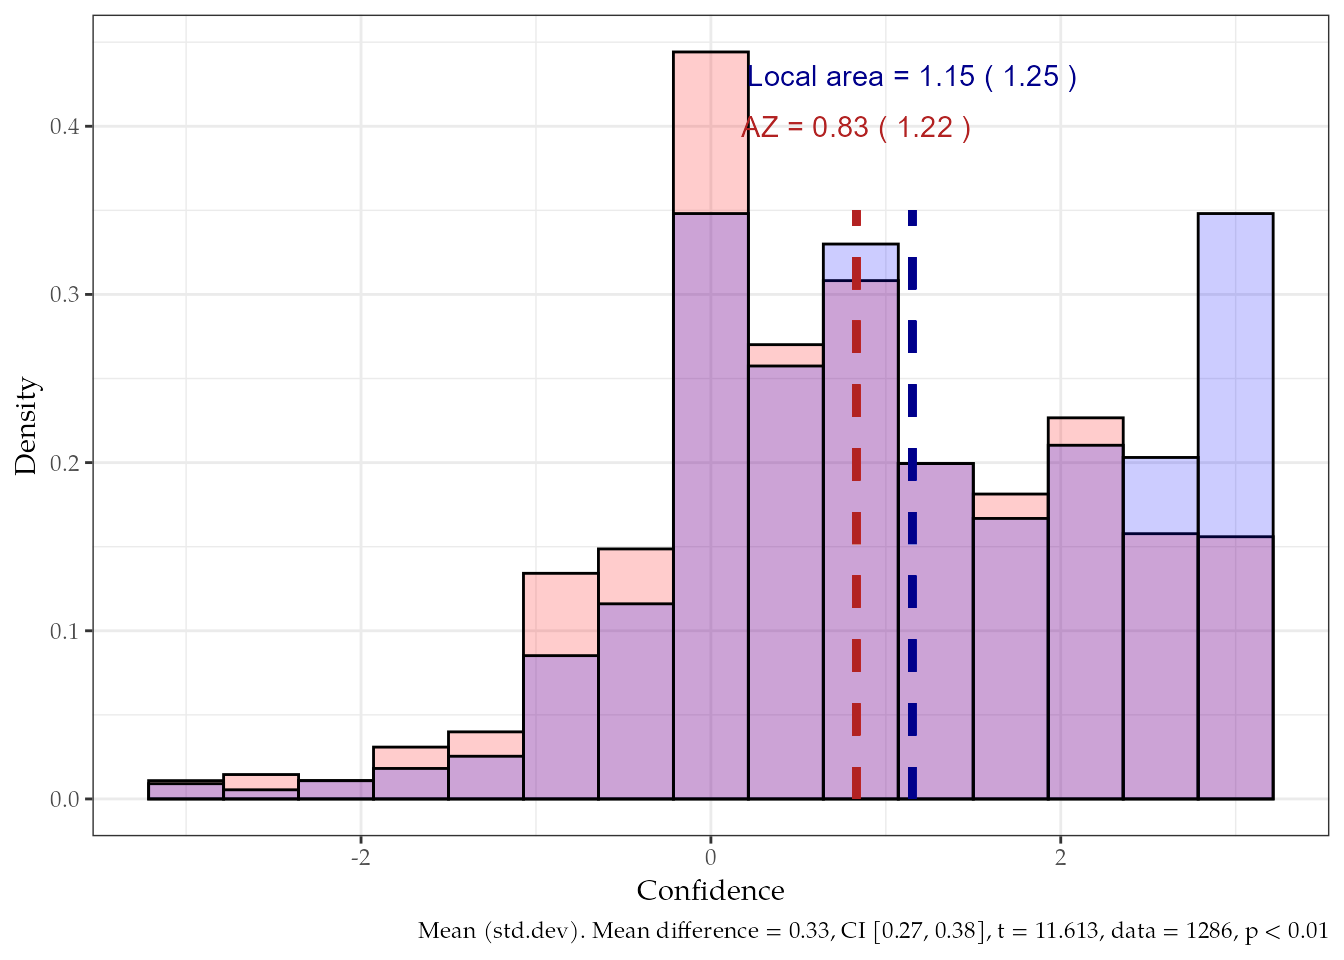

Overall, the sample expressed more trust in elections relative to distrust seeing as how the distribution of confidence is largely positive. However, there’s a clear difference between confidence in Maricopa county, AZ elections and elections within one’s local area. A paired t-test confirms that this difference was statistically significant, though somewhat small (mean difference $= 0.325$, $95\%$ CI $[0.27, 0.38]$, $t(1286) = 11.61$, $p < .001$). Nonetheless, respondents appeared less confident regarding elections in Maricopa County, AZ, but held more confidence in elections administration in their local area. This complements previous research that demonstrates a similar bias favorable to one’s local area \[@stewart2022\].

Accordingly, when confidence levels are distinguished by experiment condition, the treatment vignette only had an effect upon survey items pertaining to elections in Maricopa County, AZ. Conducting an independent samples t-test (i.e., Welch Two Sample t-test) suggests that the effect of the treatment compared to the control condition is positive and statistically significant.

[1] See Appendix D for Inter-item correlation analysis.

[2] The methodological concerns between the use of (unit weighted) sum or mean scores compared to the use of estimated factor scores for Likert scales composed of multiple Likert items are legion. The use of either computed sum scores or estimated factor scores as a general practice is continuously debated \[@mcneish2020; @widaman2022; @mcneish2023; @widaman2024\], yet there is no general consensus on the most appropriate method generally. The use of either appears to largely depend on the researcher’s particular research objective, theoretical suppositions, and necessity. Another common concern is the inappropriate treatment of ordinal variables as interval which levy strong assumptions, e.g., each item contributes equally to the variable being measured and that ordinal response categories are equidistant as though on an interval scale \[@wang2013; for contrast, see @robitzsch2020\].

[3] This range is mostly arbitrary, as a range from -1 to 1 works much the same. When relying on simple sum total score, the scale ranges from -15 to 15. So a single point increase from 0 to 1 may reflect a combination of a single “Very confident” response on a trust item compensated by a single “Somewhat likely” response on a distrust item (i.e., 3-2 = 1), or some other equivalent combination. Although the use of mean scores would place scores back onto the response scale metric (e.g., from 0 to 3, reflective of “not at all” to “very”), this results in a unipolar scale (from 0 to 3). The bipolar scale resulting from the composition of positive trust and negative distrust engenders meaning to zero and negative values. In other words, negative values on the scale for confidence in elections hold substantive meaning (e.g., distrust, absent trust), which makes transforming scores to fit a unipolar scale inappropriate.

In [ ]:
# conduct two t-tests using `rstatix::t_test`, bind results by row, and pipe
# into table
tab_ttest <- dplyr::bind_rows(
  data |> mutate(group = forcats::fct_relevel(group, "Treatment", after = 0L)) |>
  rstatix::t_test(formula = conf.az.rescaled ~ group,var.equal = F,detailed = T),
  data |> mutate(group = forcats::fct_relevel(group, "Treatment", after = 0L)) |>
  rstatix::t_test(formula = conf.lcl.rescaled ~ group,var.equal = F, detailed = T)
  ) |> 
  # specify columns and column names
  select(
    Diff = estimate,
    treat_mean = estimate1,
    control_mean = estimate2,
    treat_n = n1,
    control_n = n2,
    t = statistic,
    p, df, conf.low, conf.high) |> 
  mutate(
    Place = dplyr::case_when(
      p <= 0.05 ~ "Maricopa County, AZ", 
      p > 0.05 ~ "Local Area"), 
    .before = Diff) |> 
  insight::format_table(stars = T)

# convert from `data.frame` to `tinytable` class object
tab_ttest <- tinytable::tt(tab_ttest)

# modify column names of table
colnames(tab_ttest) <- c(
  "Place",
  "$\\bar{x}_{diff}$",
  "$\\bar{x}_{treat}$",
  "$\\bar{x}_{control}$",
  "$n_{treat}$",
  "$n_{control}$",
  "t",
  "p",
  "df",
  "CI")


# Output using `tinytable` R Package
tab_ttest |> 
  tinytable::format_tt(
    j = 2:6, # specify columns
    math = T # apply mathmode to specified columns
  ) |> 
  tinytable::style_tt(
    fontsize = 0.75, # fontsize in em units (0.75*default fontsize)
    align = "lccccccccc"
    )

Place,$\bar{x}_{diff}$,$\bar{x}_{treat}$,$\bar{x}_{control}$,$n_{treat}$,$n_{control}$,t,p,df,CI
"Maricopa County, AZ",$0.20$,$0.93$,$0.72$,$650.00$,$637.00$,2.96,0.003**,1283.73,"[ 0.07, 0.33]"
Local Area,$0.06$,$1.18$,$1.12$,$650.00$,$637.00$,0.87,0.383,1282.95,"[-0.08, 0.20]"


The results of @tbl-ttest show that, on a scale ranging from -3 to 3, the effect of the treatment is associated with a $0.20$ average difference in confidence in elections in Maricopa County, AZ, compared to the control group. When the dependent variable is centered to have a mean of $0$ and standard deviation of $1$, standardized parameters permit interpretation of the treatment effect in terms of standard deviations; the standardized difference in confidence between treatment and control is $0.16$ (CI $[0.06, 0.27]$).

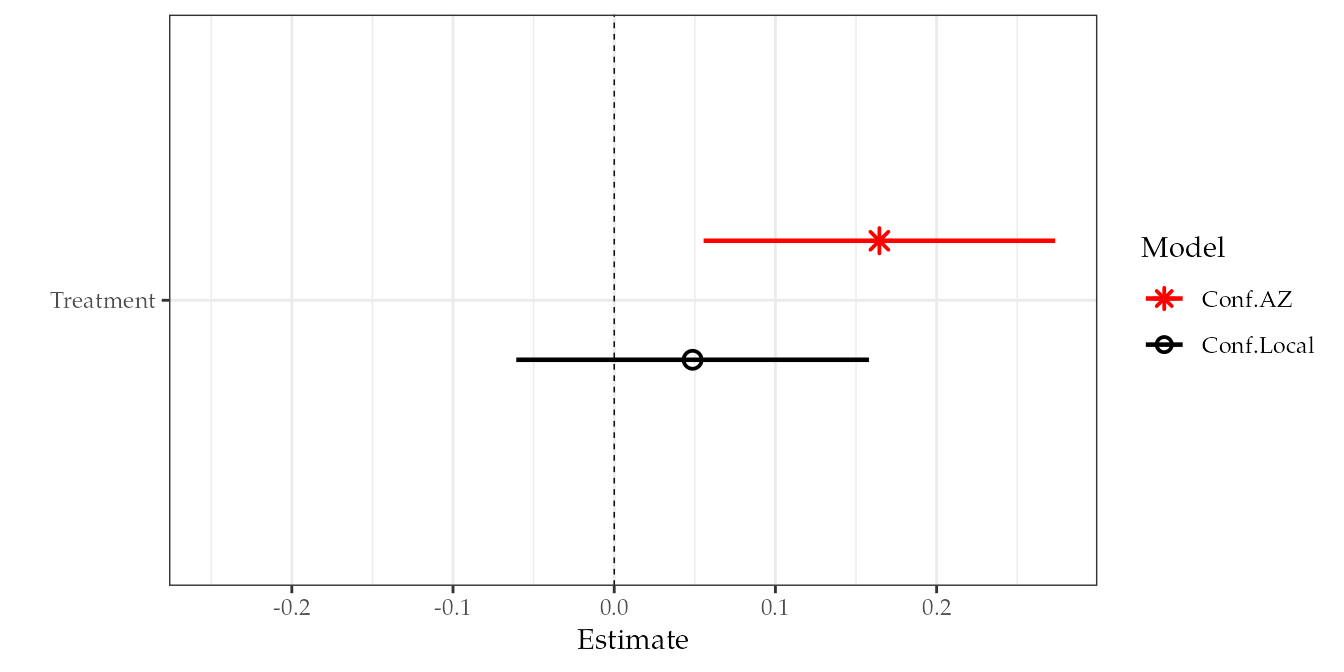

In [ ]:
# coef plot of treatment effect on confidence distinguished by location
conf.coef1 <- jtools::plot_summs(
  lm(conf.az.rescaled ~ group, data = data), 
  lm(conf.lcl.rescaled ~ group, data = data), 
  center = T, scale = T, transform.response = T,
  model.names = c("Conf.AZ", "Conf.Local"),
  coefs = c("Treatment" = "groupTreatment"), 
  colors = c("red", "black"),
  point.shape = c(8, 1))+
  ggplot2::expand_limits(x = c(-0.25, 0.25))+
  labs(y = "")+
  theme_bw(base_family = "TeX Gyre Pagella")


conf.coef1

@fig-coef1 displays standard difference estimates of two models for confidence in elections in Maricopa County, AZ, and one’s local area by treatment condition (control condition as reference).

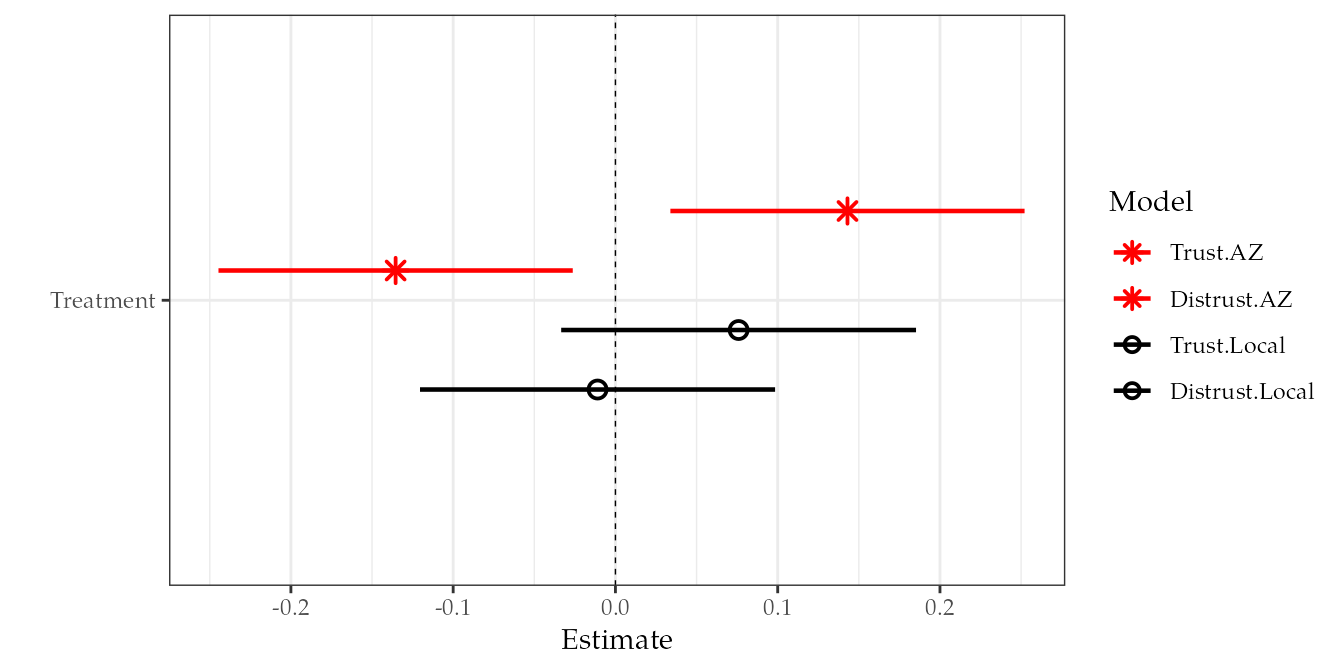

In [ ]:
# Coef plots of trust and distrust models for AZ and Local items
conf.coef2 <- jtools::plot_summs(
  lm(trust.scores.az ~ group, data = data),
  lm(distrust.scores.az ~ group, data = data),
  lm(trust.scores.lcl ~ group, data = data),
  lm(distrust.scores.lcl ~ group, data = data),
  center = T, scale = T, transform.response = T,
  model.names = c("Trust.AZ", "Distrust.AZ", "Trust.Local", "Distrust.Local"),
  coefs = c("Treatment" = "groupTreatment"),
  colors = c("red", "red", "black", "black"),
  point.shape = c(8, 8, 1, 1)
)+
  ggplot2::expand_limits(x = c(-0.25, 0.25))+
  labs(y = "")+
  theme_bw(base_family = "TeX Gyre Pagella")

conf.coef2

@fig-coef2 displays the same except *confidence* is decomposed into its two components, *trust* and *distrust*. @fig-coef2 merely illustrates the effect of the treatment with respect to the relationship between trust and distrust; ultimately confidence improves.

Confidence in elections was higher among those who read the treatment vignette but remained conditional on whether the survey questions inquired about elections in Maricopa County, AZ. This evidence suggests that announcing efforts to recruit veterans and their families to work as election staff and volunteers may increase confidence in elections administration in places outside of one’s local area, but may not boost confidence in elections within one’s local area.

The veteran cue is potentially compensatory, which supports the second hypothesis (H<sub>2</sub>). That is, the gap in confidence in local elections and elections in Maricopa County is reduced by the veterans cue, therefore compensating for the otherwise lower confidence and greater insecurity in Maricopa County elections. This is analogous to studies showing that Republicans support for a Democratic candidate is compensated by a Democratic candidate’s veteran status. Hypothetical Democratic veteran candidates were more palatable to Republican partisans than non-veteran Democrats \[@mcdermott2015\]. Similarly, Democratic veterans received higher support in Senate races, especially Democratic veteran Senate candidates whose military experience included deployment to conflict zones \[@richardson2022\].

The point of note is that it is *Democratic* candidates who receive *more* of a benefit that comes with veteran status[1]; the analogy being that it is elections located elsewhere that receive the benefits of the veteran cue whereas local elections do not. Note that the results can’t necessarily be read as differing between elections at the local level versus national level, but rather heterogeneous effects differ by elections at the local level and elections in Maricopa County, AZ. The compensatory effect of the veteran cue may generalize to other jurisdictions other than one’s local area, or the effect may be confined to Maricopa County, AZ given that this specific county had been made especially salient in the past.

### 2020 Election Legitimacy Beliefs

I now turn to results examining the effect of the treatment on those who held onto the belief that the 2020 election results were illegitimate. In short, findings support the third hypothesis (H<sub>3</sub>) allowing me to reject the null. First, reviewing responses to items that capture trust in elections, it is easy to recognize the difference between the way 2020 election deniers responded with respect to where elections were held.

``` python
p13.trust.treat.legit <- trust.az.treat.legit + trust.lcl.treat.legit+
  patchwork::plot_layout(guides = 'collect')

p13.trust.treat.legit
```

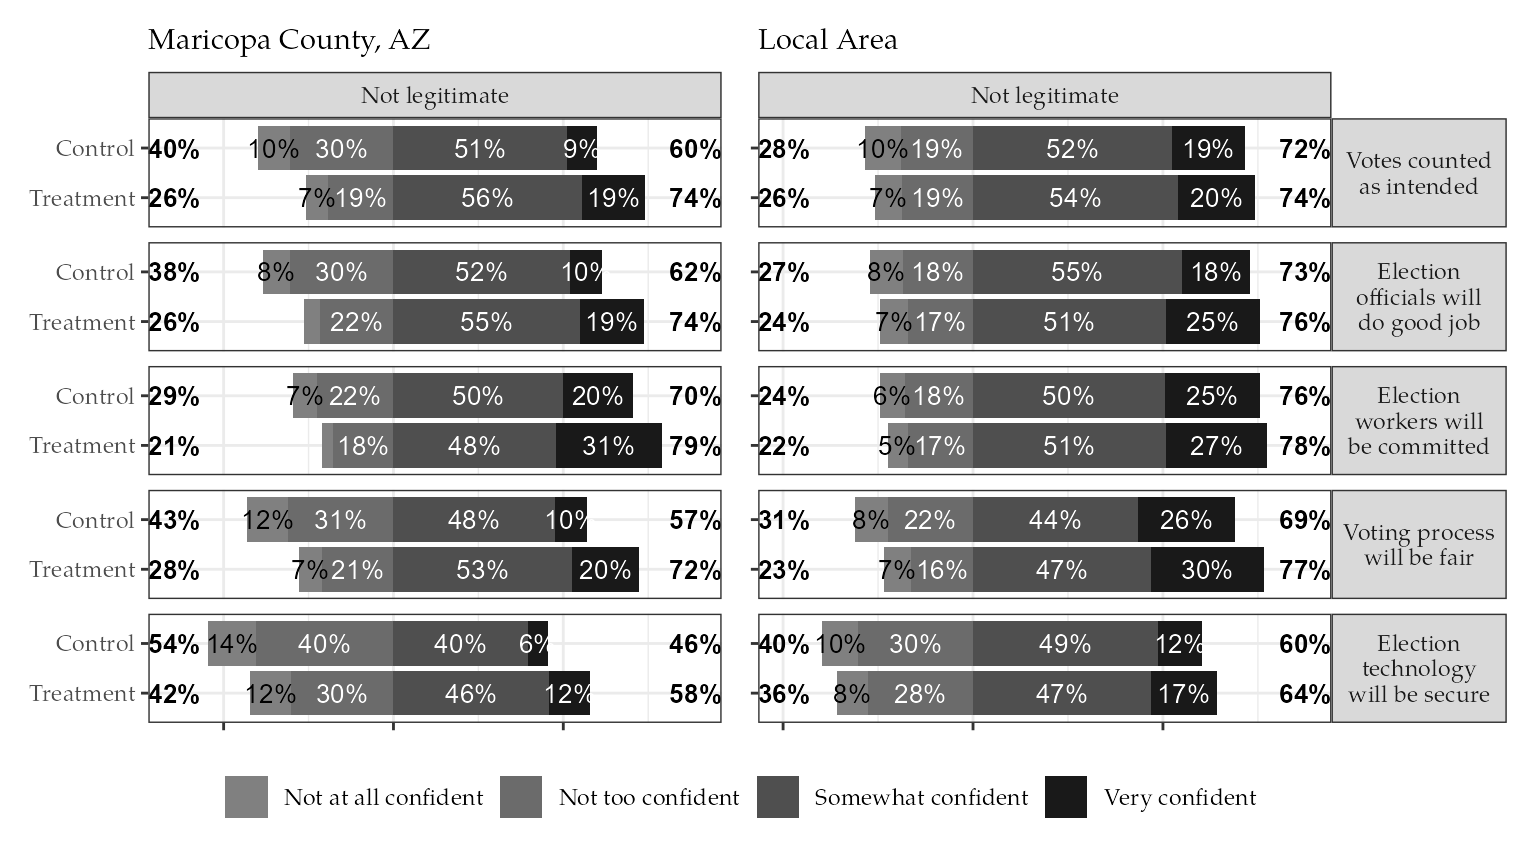

Among those who refuted the 2020 election results, trust in Maricopa County, AZ elections was lower for each item compared to items pertaining to elections within one’s local area, regardless of treatment condition. However, notably, trust that election technology would be secure received the lowest confidence endorsement overall. There was also a notable lack of trust that the voting process would be fair relative to the other items[2]. Now the comparative difference in responses between those in the treatment group compared to those in the control group appears substantial for items pertaining to elections in Maricopa County, AZ.

``` python
p14.distrust.treat.legit <- distrust.az.treat.legit + distrust.lcl.treat.legit+
  patchwork::plot_layout(guides = 'collect')

p14.distrust.treat.legit
```

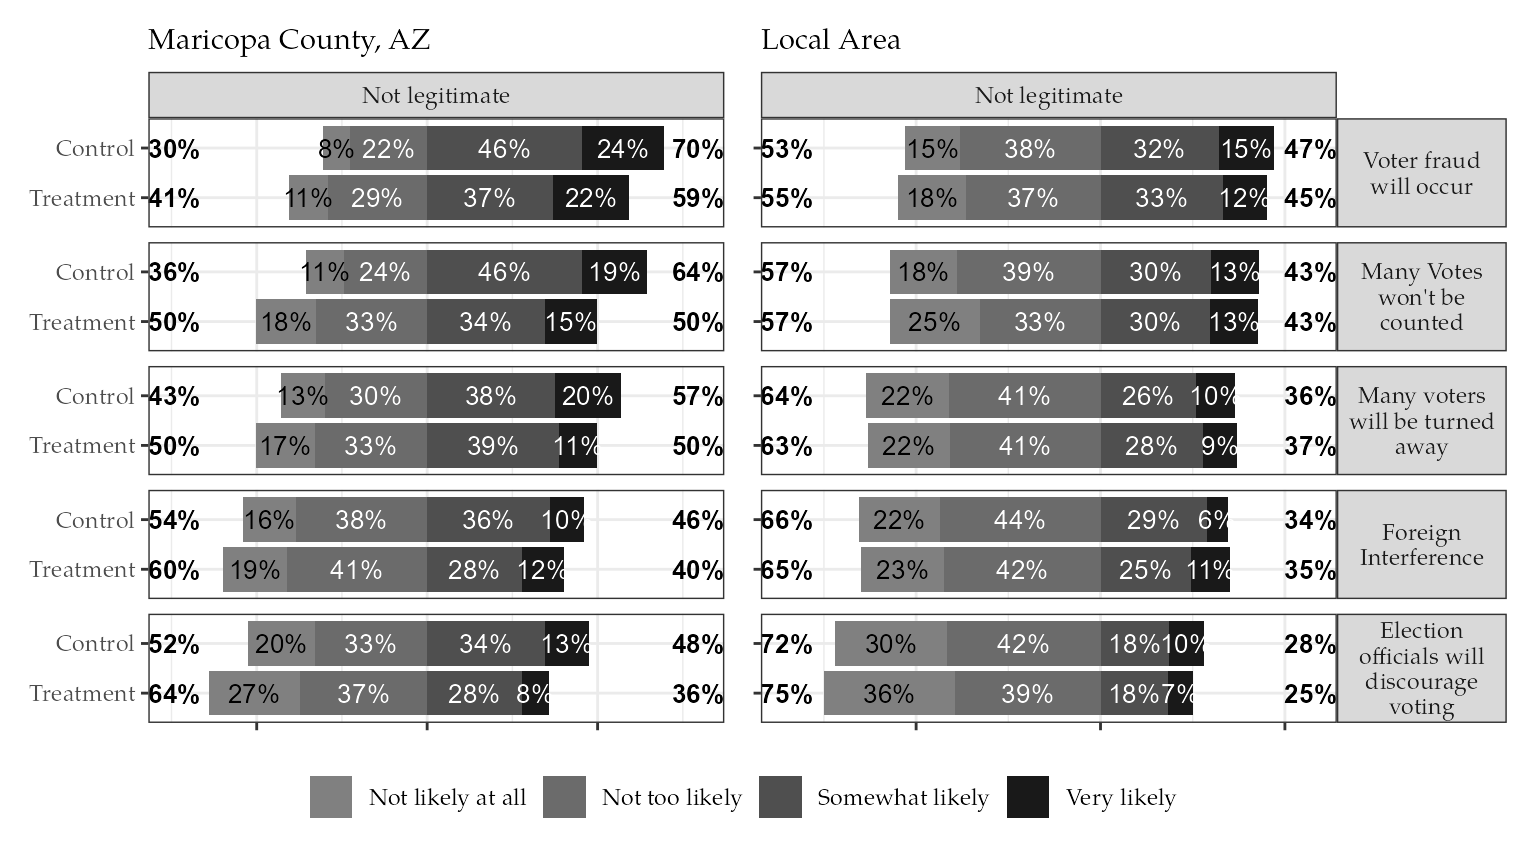

Concerning distrust among those who refuted the 2020 election results, responses to items assessing one’s expectation that election fraud would occur reveal the same pattern. Although there is not as stark a disparity between responses of those in the treatment and those in the control, among those in the treatment group, there does appear to be less expectation that election fraud would occur in Maricopa County, AZ. Overall, review of responses to trust (@fig-patch13) and distrust survey items (@fig-patch14) does lend credence to the impact of the treatment.



In order to substantiate the overall influence of the treatment on confidence in elections, I regressed the dependent variable confidence on legitimacy beliefs while controlling for partisanship.

[1] Note that the war veteran classification provided benefits to Republican Senate candidates vote share distinct from “common” veterans—i.e., Republican Senate candidates who did not deploy to areas of conflict \[@richardson2022\].

[2] What is interesting to note here is that the first three items regard the more human element of the election administration process, e.g., ensuring accuracy of counts, competence, and commitment of election workers. Although a neat line can’t really be drawn between the first three and latter two items presented here, it is interesting to see a slight divergence from the usual high confidence placed in local area elections.

In [ ]:
# All continuous variables are mean-centered and scaled by 1 standard deviation.
m1 <- lm(scale(conf.scores.az) ~ group + q7 + partyid_3cat, data = data)
m2 <- lm(scale(conf.scores.az) ~ group * q7 + partyid_3cat, data = data)

tab_legit <- modelsummary::modelsummary(
  models = list(m1, m2), fmt = 2,
  estimate = "{estimate} ({std.error}){stars}",
  statistic = NULL,
  stars = T,
  coef_rename = c(
    "(Intercept)"                        = "(Intercept)",
    "groupTreatment"                     = "Treatment",
    "q7Not legitimate"                   = "Not Legitimate",
    "partyid_3catRepublican"             = "Republican",
    "partyid_3catDemocrat"               = "Democrat",
    "groupTreatment x q7Not legitimate"  = "Not Legitimate * Treatment"),
  gof_map = c("nobs", "r2", "adj.r.squared"),
  notes = list(
    "Outcome variable mean-centered and scaled by 1 standard deviation",
    "+ p < 0.1, * p < 0.05, ** p < 0.01, *** p < 0.001"),
  width = 0.8
)

colnames(tab_legit) <- c(" ", "Confidence in AZ Elections", "w/Interaction")

tab_legit |> 
  tinytable::style_tt(
    fontsize = 0.80, # fontsize of text in table in em units (0.75*default)
    align = "lcc"
    ) |>  
  tinytable::style_tt(i = 6, line = "t") |> 
  tinytable::style_tt(i = "notes", fontsize = 0.75)

<!-- preamble start -->

 <!-- tinytable mathjax start -->
 
 
 <!-- tinytable mathjax end -->

 

 
 
 
 
 
 
 
 Confidence in AZ Elections 
 w/Interaction 
 
 
 Outcome variable mean-centered and scaled by 1 standard deviation 
 + p < 0.1, * p < 0.05, ** p < 0.01, *** p < 0.001 
 
 
 (Intercept) 
 0.03 (0.08) 
 0.07 (0.08) 
 
 
 Treatment 
 0.18 (0.05)*** 
 0.09 (0.06) 
 
 
 Not Legitimate 
 -0.72 (0.07)*** 
 -0.86 (0.09)*** 
 
 
 Republican 
 0.11 (0.08) 
 0.12 (0.08) 
 
 
 Democrat 
 0.17 (0.09)+ 
 0.17 (0.09)* 
 
 
 Treatment:Not Legitimate 
 
 0.27 (0.11)* 
 
 
 Num.Obs. 
 1263 
 1263 
 
 
 R2 Adj. 
 0.134 
 0.138 
 
 
 
 
<!-- hack to avoid NA insertion in last line -->

The first model in @tbl-legit shows that overall confidence in elections among those who read the treatment vignette was significantly (statistically) greater than those who read the control, on average and netting out the effects of partisanship and legitimacy beliefs. Democratic partisanship remains marginally significant at $90\%$ confidence level ($p = 0.055$) compared to the reference group (Independents). Not believing the 2020 election of Joe Biden was legitimate is negatively associated with confidence in elections. In order to assess the magnitude of this interaction effect of the treatment on those who refuted the 2020 election results, I ran a model where confidence in elections was regressed on the interaction between the treatment and legitimacy beliefs, controlling for partisanship.

There’s a positive interaction effect of the treatment vignette among those who believe that the 2020 election was not legitimate, on average and controlling for partisanship. This shows that the treatment effect was most influential upon those who believe the 2020 election results were illegitimate. The treatment alone does not reverse such beliefs, but this shows where its influence was most potent.

### Concerns for Violence and Voter Safety

While confidence in elections is one concern, it is not the only concern that arises in anticipation of US elections; the public must feel confident that voters are safe to cast a ballot in person. The survey included questions[1] that allowed me to assess whether those in the treatment condition expressed less concern for violence and more confidence in voter safety compared to those in the control condition.

[1] See @tbl-6 in Appendix A

In [ ]:
# concern for violence by treatment
bar_q25 <- custom_barplot(
  data = data, 
  x = q25, 
  group = group,
  subtitle = str_wrap(attr(data$q25, "label"), width = 85)
  )+
  theme(text = element_text(family = 'TeX Gyre Pagella'),
        legend.position = "right")


# confidence in voter safety by treatment
bar_q26 <- custom_barplot(
  data = data, 
  x = q26, 
  group = group,
  subtitle = str_wrap(attr(data$q26, "label"), width = 85)
  )+
  theme(text = element_text(family = 'TeX Gyre Pagella'),
        legend.position = "right")

In [ ]:
bar_q25
bar_q26

Briefly reviewing @fig-safety1, those in the treatment condition felt less concern over the potential for violence compared to those in the control.

As for confidence in voter safety at election sites, it appears that more respondents in the treatment condition expressed that they were “Very confident” compared to those in the control, by approximately $8$ percentage points.

It would appear that the treatment vignette increased the likelihood that a respondent would select a higher response option compared to those in the control group. In order to assess whether that was the case, I conducted an ordered logistic regression on the relevant items using the experimental condition as a dichotomous predictor.

In [ ]:
# needed to duplicate `group` variable with different column name due to
# conflict with marginaleffects R package
data <- data |>
  mutate(condition = group)

# running ordinal logisitc regression models (proportional odds logistic regression)
m.q25 <- MASS::polr(q25 ~ condition, data = data, method = "logistic", Hess = T)
m.q26 <- MASS::polr(q26 ~ condition, data = data, method = "logistic", Hess = T)
m.q36 <- MASS::polr(q36 ~ condition, data = data, method = "logistic", Hess = T)
m.q37 <- MASS::polr(q37 ~ condition, data = data, method = "logistic", Hess = T)

# "Outcome predicted by a fitted model on a specified scale for a given
# combination of values of the predictor variables, such as their observed
# values, their means, or factor levels (a.k.a. "reference grid")".

# predictions(): unit-level (conditional) estimates.

# predicted probability estimates by treatment or control
q25_preds <- marginaleffects::predictions(m.q25, by = "condition", type = "probs")
q26_preds <- marginaleffects::predictions(m.q26, by = "condition", type = "probs")
q36_preds <- marginaleffects::predictions(m.q36, by = "condition", type = "probs")
q37_preds <- marginaleffects::predictions(m.q37, by = "condition", type = "probs")

# this provides the difference in predicted probabilities between treatment and
# control
pdiff_q25 <- marginaleffects::predictions(
  m.q25,
  by = "condition",
  type = "probs",
  hypothesis = ~ reference | group
)

pdiff_q26 <- marginaleffects::predictions(
  m.q26,
  by = "condition",
  type = "probs",
  hypothesis = ~ reference | group
)

In [ ]:
tab_q25_pdiff <- pdiff_q25 |>
  dplyr::as_tibble() |>
  dplyr::rename(
    Violence = group,
    z = statistic,
    'Pr(>|z|)' = p.value) |>
  select(Violence,
         hypothesis,
         estimate,
         std.error,
         z,
         'Pr(>|z|)',
         conf.low,
         conf.high) |>
  insight::format_table(stars = T, digits = 3)

tinytable::tt(
  tab_q25_pdiff,
  notes = "Results derived from proportional odds logistic regression model. Estimates are differences in predicted probabilities transformed from log odds ratios, and represent difference in estimated prediction of choosing a particular response or higher") |> 
  tinytable::style_tt(
    fontsize = 0.80, # fontsize of text in table in em units (0.75*default)
    align = "lcccccc"
    ) |>  
  tinytable::style_tt(i = "notes", fontsize = 0.75)

<!-- preamble start -->

 <!-- tinytable mathjax start -->
 
 
 <!-- tinytable mathjax end -->

 

 
 
 
 
 
 
 Violence 
 hypothesis 
 estimate 
 std.error 
 z 
 Pr(>|z|) 
 conf.int 
 
 
 Results derived from proportional odds logistic regression model. Estimates are differences in predicted probabilities transformed from log odds ratios, and represent difference in estimated prediction of choosing a particular response or higher 
 
 
 Very concerned 
 (Treatment) - (Control) 
 -0.027 
 0.011 
 -2.463 
 0.014 
 [-0.048, -0.005] 
 
 
 Somewhat concerned 
 (Treatment) - (Control) 
 -0.037 
 0.015 
 -2.468 
 0.014 
 [-0.066, -0.008] 
 
 
 Not too concerned 
 (Treatment) - (Control) 
 0.032 
 0.013 
 2.460 
 0.014 
 [ 0.007, 0.058] 
 
 
 Not at all concerned 
 (Treatment) - (Control) 
 0.031 
 0.013 
 2.472 
 0.013 
 [ 0.006, 0.056] 
 
 
 
 
<!-- hack to avoid NA insertion in last line -->

Shown in @tbl-preds-diff1, those in the treatment condition had lower probability to express that they were ‘Very’ or ‘Somewhat’ concerned for violence in Maricopa County, AZ Elections, yet higher probability of expressing ‘Not too’ or ‘Not at all’ concerned.

In [ ]:
tab_q26_pdiff <- pdiff_q26 |>
  dplyr::as_tibble() |>
  dplyr::rename('Voter Safety' = group,
                z = statistic,
                'Pr(>|z|)' = p.value) |>
  select('Voter Safety',
         hypothesis,
         estimate,
         std.error,
         z,
         'Pr(>|z|)',
         conf.low,
         conf.high) |>
  insight::format_table(stars = T, digits = 4)

tinytable::tt(
  tab_q26_pdiff,
  notes = "Results derived from proportional odds logistic regression model. Estimates are differences in predicted probabilities transformed from log odds ratios, and represent difference in estimated prediction of choosing a particular response or higher") |>  
  tinytable::style_tt(
    fontsize = 0.80, # fontsize of text in table in em units (0.75*default)
    align = "lcccccc"
    ) |>  
  tinytable::style_tt(i = "notes", fontsize = 0.75) # style font of table notes

<!-- preamble start -->

 <!-- tinytable mathjax start -->
 
 
 <!-- tinytable mathjax end -->

 

 
 
 
 
 
 
 Voter Safety 
 hypothesis 
 estimate 
 std.error 
 z 
 Pr(>|z|) 
 conf.int 
 
 
 Results derived from proportional odds logistic regression model. Estimates are differences in predicted probabilities transformed from log odds ratios, and represent difference in estimated prediction of choosing a particular response or higher 
 
 
 Not at all confident 
 (Treatment) - (Control) 
 -0.0166 
 0.0048 
 -3.4331 
 0.0006 
 [-0.0260, -0.0071] 
 
 
 Not too confident 
 (Treatment) - (Control) 
 -0.0444 
 0.0120 
 -3.6929 
 0.0002 
 [-0.0680, -0.0208] 
 
 
 Somewhat confident 
 (Treatment) - (Control) 
 -0.0198 
 0.0066 
 -3.0095 
 0.0026 
 [-0.0327, -0.0069] 
 
 
 Very confident 
 (Treatment) - (Control) 
 0.0808 
 0.0215 
 3.7637 
 0.0002 
 [ 0.0387, 0.1228] 
 
 
 
 
<!-- hack to avoid NA insertion in last line -->

As for confidence in voter safety in @tbl-preds-diff2, moving from treatment to control, the difference in predicted probability of a respondent selecting “Very Confident” was $0.08$. Both tables show the significant differences in predicted probabilities at 95$\%$ confidence[1]. These findings support both H<sub>4a</sub> and H<sub>4b</sub> respectively, permitting rejection of the null for each hypothesis.

## Discussion

The research question emerged in light of the recent surge of efforts nationwide to recruit veterans to serve as election workers \[@lawrence2022; @wentling2024\] midst an environment where election insecurities were heightened and intensified. Heightened insecurities in anticipation of upcoming elections do not merely pertain to the election outcome (e.g., who wins), but to one’s general sense of confidence in the administration of elections, the integrity of the electoral process, and to the safety of casting a ballot in-person. This study demonstrated that information neutral to the trustworthiness of election administration can not only improve trust in elections, but simultaneously reduce distrust in elections. Those who were presented information about veteran recruitment efforts reported greater trust that votes will be counted accurately, that election staff will competently administer elections, that election technology will be secure from nefarious tampering, and that the process will be fair for all involved. Moreover, those presented with information about veteran recruitment efforts reported lower expectations that electoral fraud will occur. They also felt that election sites would be safe for voters to cast a ballot in person and were less concerned about potential violence compared to those who were not presented information about veteran recruitment efforts.

Confidence in elections was greater among those who read the treatment vignette announcing efforts to recruit veterans to work as election staff and volunteers, but this effect was conditional on whether survey questions asked about elections Maricopa County, AZ. When survey questions asked about elections in one’s local area, confidence in elections among the treatment group was not significantly different from the control group. However, the sample’s confidence in their local area elections was high in general relative to elections in Maricopa County, AZ (@fig-dist). The results presented here suggest that the effect of the veteran cue in the treatment vignette is compensatory. That is, the gap in confidence in local elections and elections in Maricopa County is reduced by the veterans cue, therefore compensating for the otherwise lower confidence and greater insecurity in Maricopa County elections.

A question lingers about whether some antecedent mechanism transmits (i.e., mediates) the effects of the veteran treatment vignette to the outcome. To put simply, this study reiterates that there *is* something special about veterans in particular that elicits greater confidence in elections, but cannot go further in determining exactly *what* that special something might be. Factors that *moderate* the relationship of the treatment on the outcome of interest are likely plenty, but one can only offer conjecture of a *mediator* driving results.

One potential explanation is that veterans, and all those who serve in the military, potentially function as a national symbol. The group is abstract just as the nation is abstract, and the potency of the veteran group emulates the potency of a national symbol. Recall Benedict Anderson’s \[-@anderson2006\] meditation on the Tomb of the Unknown Soldier, “…saturated with ghostly *national* imaginings” \[-@anderson2006, 9, emphasis original\]. In various studies, national symbols such as the flag, the national anthem, or even mere appeal to national identity have potent, yet variable, effects on different outcomes \[@schatz2007; @butz2007; @kemmelmeier2008; @butz2009; @gangl2016; @kalmoe2016; @levendusky2018\]. It is plausible that military service members and veterans function in much the same way—as a symbol of national loyalty, pride, and nationalism for people to praise and revere out of a sense of duty prescribed by social norm and reinforced by national sentiment. As such, it may be the case that the treatment effect on confidence in elections is mediated through an affective response to a national symbol—in this case, veterans. The veteran cue may indeed stimulate national sentiment and subsequently boost confidence in elections.

In results presented here, confidence in elections is associated with greater confidence among those in the treatment group, but neither vignette conveys information about the procedures or practices meant to safeguard election integrity; nothing in the treatment suggests to respondents that election integrity would be improved by recruiting veterans. Arguably, the results presented here speak to the “emotional pathway” mentioned in @gaudette2025 so long as we assume that there’s an inherent appeal to national sentiment (e.g., nationalism, patriotism) by use of veterans[2]. Importantly, if the veterans treatment is mediated by stimulation of affect for nation or national identity, then comparable stimulation of national sentiment unrelated to veterans should produce similar results via this “emotional-pathway”. However, appeals to national sentiment by use of sterile national symbols (e.g., banal presentation of the U.S. flag, playing of the national anthem) may not have the same affective influence on confidence in elections.

In a similar vein, it is plausible that certain political apprehensions are nullified insofar as veterans as a group are generally perceived as ‘apolitical’—which itself may be enough to engender favor among the mass public \[@krupnikov2022\]. Current and former military service members may be viewed by the public generally as ‘apolitical’, especially in comparison to practically any other social group. Indeed, an ‘apolitical’ reputation has been long desired by military leaders and top brass \[@lagrone2019; @garamone2016; @garamone2016a; @baldor2020\] despite evidence to the contrary \[@betros2001; @mcnerney2006\]. Nevertheless, the putative ‘apolitical’ nature of military service may generalize to veteran service members, and increase confidence in elections based on the assumption that veterans uphold a commitment to ensure election integrity above their own personal loyalties, partisanship, or politics. Prior research has relied on the assumption that such a “*group-based*” norm persists among military members, which prescribes that the military is, or ought to be, apolitical \[@mullinix2022\]. Although, the extent to which this perception generalizes widely among the mass public about the military in general, or about current and former service members in particular, has yet to be examined. Given recent events of far more overt politicization of the U.S. military \[@baldor2025; @baldor2025a; @baldor2025b; @baldor2025c; @thomas2025\], it would be useful for future research to consider whether perceptions about the military generally, and military leaders in particular, generalize to perceptions about current and former military service members. Especially insofar as such attitudes relate to confidence in the electoral process and administration.

It is difficult to compare magnitude of effect with other studies given that the item number, item wording, measurement, and computation of confidence in elections is unique across most individual studies to include this one. For instance, @gaudette2025 doesn’t compose multiple items into a single composite measure, but subtracts pre-treatment values from post-treatment values for single-item measures with Likert-style response options. Whereas @clayton2023 develops a scale referred to as “Trust in American electoral process” by taking the mean from three items. The item wording of that scale is markedly similar to the items used to compose the trust scale of this study, but the range of response options differs considerably. Thus, while most studies examining public confidence in elections often include the core question “How confidence are you that your vote \[will be/was\] counted as you intended in the most recent election?”, the different ways that researchers measure and compute variable scores on the outcome most often produces results that are, unfortunately, sample dependent. The study of public confidence in elections is in desperate need of a standard method of measurement, or even a screened and validated item bank, and this study may be seen as a baby step to that end.

That being said, this study generally emulates treatment effects of comparable studies in the literature. @gaudette2025 found positive effects of official messaging from election officials on various items measuring trust in elections and expectations of electoral fraud. Similarly, @clayton2023, confined to a sample of Republican participants, found positive influence on perceptions of 2020 election legitimacy and trust in the American electoral process from official messaging by Republican politicians reaffirming the 2020 election results.

The data of the current study is limited in helping to discern whether the treatment garners greater confidence in elections uniformly across different racial or ethnic groups given that the largest proportion of the sample identified their race as White (77%). It is reasonable to suspect that the treatment vignette might differ by race and ethnicity, but the sample is insufficient to make such generalizations. Nevertheless, attitudes about veterans that differ by group may play an important role in determining whether publicized efforts to recruit military veterans boosts confidence in elections uniformly or whether the effect is merely partial to certain segments of the population.

It is definitely plausible that the public, to some unknown extent, associates a particular gender or race, or both, with former and active military members which may, in turn, mediate the effect of the veteran cue. Additionally, I can’t be sure as to whether respondent’s views of the military generalize to attitudes about active service members and veterans. However that is a separate question about the source of public opinion about military members themselves beyond the scope of this study.

There’s scant research or evidence available to postulate a well-formed theory on the mechanism underlying the expected effects of veterans as a group on attitudes about institutions and processes, rather than on attitudes about persons or groups. That is to say, there’s not much research on how the public feels, or what they think, about former members of the U.S. Armed Forces.

In their research examining whether groups differed in attitudes about veterans, @kleykamp2018 could only speculate as to why levels of support were lowest among Hispanic and Black respondents. Their study was distinctive in that it stands as a rare case in which public attitudes about veteran military members was the specific focus of inquiry as opposed to studies that examine public opinion about the military in general. Other research has found that attitudes about the U.S. military generally—though not about active or veteran military service members in particular—differs by race and ethnicity to varying extents, but also could not supply reason for one groups’ sentiment over another[3] \[@nichols2015\].

Other studies have drawn out disparities in public attitudes about veterans but in ways that are mostly indirect, i.e., without assessing public regard for veterans directly. One overarching issue is that there’s limited research that differentiates public regard for veteran and active military service members from the U.S. military as an institution in general. Some studies assess public regard for veterans indirectly by examining whether, and to what extent, endorsement of certain policies differentiate by whether such policies benefit veterans or the public generally. In one such study by @tsai2021, Republican partisanship was shown to be the most consistent factor associated with more favorable attitudes (e.g., compassion) toward homelessness and PTSD among the veteran population, but not among the general adult population. Additionally, Republican partisans tended to show greater support for federal funding for homelessness and PTSD research when the reference population was military veterans. That study, however, suggests that the effect of the veteran status cue is sensitive to the topic in question.

Perhaps unsurprisingly, military veterans appear to be uniquely deserving in the eyes of Republican partisans \[@tsai2021; @mcdermott2015; @richardson2022\]. As such, military veteran status may qualify favorable attitudes among Republican partisans whereas their regard for other non-veteran groups might otherwise express contempt or indifference. This further indicates a need for research to determine an underlying mechanism explaining why, and for whom, veterans incur special favor.

## Limitations

The bluntness of the experimental stimulus and survey items don’t allow us to establish exactly what it is about military veterans in particular that cues stronger confidence in elections. No survey items assessed public attitudes about military veterans specifically, pre- nor post-treatment. This unfortunately leaves no room for me to postulate and examine any potential mechanisms underlying results.

It should be noted that these results are limited to one’s expectations in anticipation of election night. Whether the increase in confidence is sustained post-election night cannot be inferred from these results. Moreover, It is yet unclear whether actually encountering and interacting with veterans working as staff or volunteers at election sites does much to improve voter confidence after election night compared to anyone else. It may be the case that assumptions that veterans are filling spots as election workers and volunteers simply primes positive expectations as one heads into an election site, potentially improving voters perceptions of their own experience on the way out. Further research would be needed to test such an idea.

The setting of the vignette and specified in survey items might raise additional concerns on whether results are generalizable. Naming a specific county in the vignette adds in a potentially influential factor unaccounted for in the survey; some people may have attitudes about the county in question, others won’t, while others may be muffed to consider a random county in the U.S. they know nothing about. Naming a real and somewhat salient county potentially undermines confidence that the treatment effects are solely attributable to veterans to an unknown degree. Simply put, there may be something special about Maricopa County, AZ in particular that generalizes across attitudes of trust or distrust in elections.

Arguably, however, Maricopa County is indicated as the setting in both the treatment and control vignettes, thus the only actual difference between conditions is constrained to the target group being recruited. Future research may employ vignettes naming a fictional U.S. county to hopefully eliminate the setting as a concern. Alternatively additional survey items that ask directly about one’s knowledge or sentiment about the county in question could inform researchers on whether the named county imposes any undue influence at all, or whether the setting is associated with other factors such as partisanship.

As stated previously, the survey was fielded on a non-probability sample of 1,287 U.S. citizens 18 years of age or older. The results presented here are not assumed to be generalizable to the national population. It may be feasible to weigh the sample to demographics of the population at the time the survey was fielded, but this is unnecessary for the experimental purpose of the study. If similar findings complement or replicate these results, then the expense of drawing samples more representative of the national population may be justified. At this stage, however, the results are limited to demonstrating treatment effects.

Note also that the measurement items of the components trust and distrust, and the method of computing scores for the dependent variable, confidence in elections, are unique to this study but falls under the methodological framework of Classical Test Theory (CTT). Although survey measurement items were either directly drawn from or inspired by similar survey items found in various other surveys (e.g., SPAE, Pew), the question wording, response choices, coding, and computation of sum scores of the dependent variable are specific, thus rendering measurement of the hypothetical constructs of interest (i.e., trust, distrust) less comparable across similar studies that profess measurement of similar constructs \[@widaman2024\]. Namely, trust, distrust, or confidence in elections as defined and measured here.

## Conclusion

Publicized announcements that election officials are actively recruiting former military service members to work as election staff and volunteers is associated with greater confidence in elections compared to election worker recruitment announcements that do not explicitly mention targeted efforts to recruit former military service members. In addition, such public announcements eased concerns about violence and increased confidence that voters would be safe to vote in person at election sites. Of course, the higher levels of confidence in elections and voter safety observed among the treatment group were limited to considerations about elections held in Maricopa County, AZ—presumably beyond one’s local area. This is to be expected bearing in mind that confidence in elections for one’s local area is usually higher than for those beyond. Thus, there’s already more insecurity concerning elections elsewhere for whatever reason.

One obvious contribution of these results shows that the perceived trustworthiness of elections administration is amendable to generalized impressions about the kind and character of the people who work and volunteer as election staff. Whatever election officials do to boost public confidence may be overshadowed by impressions about who is staffing election sites.

In general, public confidence appears strongest when the elections under consideration regard those within one’s local community. Yet, such strong confidence is not generalized outward to the institution of elections administration as a whole. Insecurity in the integrity of the electoral process and its administration may be naturally higher for elections that occur further from home. Whether that is due to some local favorability bias or some outward negativity bias is hard to say. And seeing as how insecurity presents vulnerability, it is perhaps far easier to inspire a general sense of distrust in the process and its administration in places more abstract.

In the anticipatory period prior to national elections, publicized efforts to recruit veterans to work as election staff and volunteers may be a small, but positive, step towards reducing insecurity in elections that occur elsewhere. Especially among those who maintained a steadfast degree of distrust in elections. Despite a lack of evidence that systematic electoral fraud had occurred in the 2020 election, a substantial proportion of the population were unwilling to affirm the legitimacy of the results. However, despite such legitimacy beliefs, most were not consistent as they expressed varying levels of trust in different aspects of elections administration. These results say more about the influence that military veterans have among those who are most insecure than it does about the public more generally.



# Appendix A: Survey Experiment Vignettes and Survey Items

## Survey Experiment Vignettes



[1] The same models were run for items pertaining to safety concerns in one’s local area but results of the treatment were not significantly different from the control. See Appendix E for full results table of ordinal logistic regression

[2] The study by @gaudette2025 included an experiment that examined the contrast between “emotional” versus “informational” appeals on trust in elections and beliefs that election fraud is prevalent. Authors presented one of two video messages created by election administration officials in either Virginia or Maricopa County, AZ; the former was “emotions-based” in that it provided little to no information about the voting process or election administration, whereas the latter provided, “…specific information about the processes used to ensure the integrity of the vote with no appeal to emotion or patriotism” \[-@gaudette2025, 13\].

[3] Note, however, that the sample examined by @nichols2015 was constrained to Texas residents, and the military-related issues concerned, among other things, favor for reinstatement of a military draft, support for allowing undocumented immigrants who live in the U.S. to serve in the U.S. Armed Forces, and whether undocumented immigrants should be granted U.S. citizenship as a result of military service. Although the authors found high overall support for the military as an institution, the other military-related attitudes of interest diverge far from public opinion about veterans. As such, differential effects found among different racial or ethnic groups likely have little to do with attitudes about former or active military service members.

In [ ]:
var_label_tab <- function(x){
    purrr::map(x, ~attr(., "label")) |>
    purrr::map(~ifelse(purrr::is_null(.), "No label", .)) |>
    tibble::enframe(name = "var", value = "var_label") |>
    tidyr::unnest(cols = c(var_label))
}


Questions <- data |> 
  dplyr::select(q7, q25, q26, q36, q37) |>
  dplyr::rename_with(.cols = everything(), .fn = ~snakecase::to_any_case(.,case = "upper_camel")) |> 
  var_label_tab() |>
  dplyr::select(Question = var_label) |> 
  dplyr::pull(Question)

items_responses <- data.frame(
  Questions = Questions,
  Response =c(
    "- Legitimate\n- Not legitimate",
    "- Very concerned\n- Somewhat concerned\n- Not too concerned\n- Not at all concerned",
    "- Not at all confident\n- Not too confident\n- Somewhat confident\n- Very confident",
    "- Very concerned\n- Somewhat concerned\n- Somewhat unconcerned\n- Not at all concerned",
    "- Not at all confident\n- Not too confident\n- Somewhat confident\n- Very confident")
)
  
  
# wrap in a minipage environment
minipagify <- function(x) {
  sprintf(
    "\\minipage{\\textwidth}%s\\endminipage",
    sapply(x, mark, "latex")
  )
}

# only in LaTeX
is_latex <- identical(knitr::pandoc_to(), "latex")

tab <- tinytable::tt(items_responses, width = c(0.7, 0.3)) |>
  tinytable::style_tt(j = c(1,2), fontsize = 0.8, align = "l") |>
  tinytable::format_tt(markdown = TRUE) |>
  tinytable::format_tt(j = 2, fn = if (is_latex) minipagify else NULL)

tab

Questions,Response
"Regardless of whom you supported in the 2020 election, do you think Joe Biden’s election as president was legitimate, or was he not legitimately elected?",Legitimate Not legitimate
"Thinking about Maricopa County, AZ, how concerned should voters feel about potential violence, threats of violence, or intimidation while voting in person at their local polling place?",Very concerned Somewhat concerned Not too concerned Not at all concerned
"How confident, if at all, are you that in person polling places in Maricopa County, AZ will be safe places for voters to cast their ballots during the upcoming elections in November?",Not at all confident Not too confident Somewhat confident Very confident
"Thinking about your local area, how concerned should voters feel about potential violence, threats of violence, or intimidation while voting in person at their local polling place?",Very concerned Somewhat concerned Somewhat unconcerned Not at all concerned
"How confident, if at all, are you that in person polling places in your local area will be safe places for voters to cast their ballots during the upcoming elections in November?",Not at all confident Not too confident Somewhat confident Very confident




# Appendix B: Sample Demographics and Balance

## Sample Demographics

In [ ]:
# descriptive stats of categorical variables
# gtsummary method
gtsummary::theme_gtsummary_compact()

Setting theme "Compact"

Variable,Overall (N = 1287),Control (N = 637),Treatment (N = 650)
"Age group, in years",,,
18-34,350 (27%),170 (27%),180 (28%)
35-54,480 (37%),245 (38%),235 (36%)
55-74,390 (30%),198 (31%),192 (30%)
75-85+,67 (5.2%),24 (3.8%),43 (6.6%)
Gender,,,
Male,598 (47%),289 (46%),309 (48%)
Female,658 (52%),330 (52%),328 (51%)
Other/Refused,16 (1.3%),10 (1.6%),6 (0.9%)
NA,15,8,7


In [ ]:
tbl.desc2 <- data |>  
  gtsummary::tbl_summary( 
    by = group,
    label = list(
      partyid_3cat = "Party ID",
      ideo_3cat = "Political Ideology",
      ideolean = "If R had to choose Political Ideology",
      voted2020 = 'Did R Vote in 2020 Election',
      choice2020 = 'Vote Choice in 2020 Election'),
    include = c(
      partyid_3cat,
      ideo_3cat, 
      ideolean, 
      voted2020, 
      choice2020),
    statistic = list(gtsummary::all_categorical()~ "{n} ({p}%)"), 
    missing = "ifany",
    missing_text = "NA") |> 
  gtsummary::add_overall() |> 
  gtsummary::modify_header(label = "**Variable**") |> 
  gtsummary::bold_labels()

tbl.desc2 |>
  gtsummary::as_tibble() |>
  dplyr::rename('**Overall (N = 1287)**' = "**Overall**  \nN = 1,287",
                "**Control (N = 637)**" = "**Control**  \nN = 637",
                "**Treatment (N = 650)**" = "**Treatment**  \nN = 650") |>
  tinytable::tt(theme = "spacing") |>
  tinytable::format_tt(markdown = T) |>
  tinytable::format_tt(replace = " ") |>
  tinytable::style_tt(fontsize = 0.70, align = "lccc")

Variable,Overall (N = 1287),Control (N = 637),Treatment (N = 650)
Party ID,,,
Independent,162 (13%),83 (13%),79 (12%)
Republican,540 (43%),262 (42%),278 (43%)
Democrat,566 (45%),283 (45%),283 (44%)
NA,19,9,10
Political Ideology,,,
Liberal,392 (31%),201 (32%),191 (30%)
Conservative,412 (33%),205 (33%),207 (32%)
Extremely Liberal,0 (0%),0 (0%),0 (0%)
Slightly liberal,0 (0%),0 (0%),0 (0%)


In [ ]:
tbl.desc3 <- data |>  
  gtsummary::tbl_summary( 
    by = group,
    label = list(
      milserv1 = "Military Service",
      milserv2 = "Current Active Duty",
      milservfam = "Military Service within Family?"
      ),
    include = c(
      milserv1,
      milserv2, 
      milservfam), 
    type = list(
      milserv1 ~ "categorical",
      milserv2 ~ "categorical",
      milservfam ~ "categorical"
      ),
    statistic = list(gtsummary::all_categorical()~ "{n} ({p}%)"), 
    missing = "ifany",
    missing_text = "NA") |> 
  gtsummary::add_overall() |> 
  gtsummary::modify_header(label = "**Variable**") |> 
  gtsummary::bold_labels()

tbl.desc3 |>
  gtsummary::as_tibble() |>
  dplyr::rename('**Overall (N = 1287)**' = "**Overall**  \nN = 1,287",
                "**Control (N = 637)**" = "**Control**  \nN = 637",
                "**Treatment (N = 650)**" = "**Treatment**  \nN = 650") |>
  tinytable::tt(theme = "spacing", width = 1) |>
  tinytable::format_tt(markdown = T) |>
  tinytable::format_tt(replace = " ") |>
  tinytable::style_tt(fontsize = 0.70, align = "lccc")

Variable,Overall (N = 1287),Control (N = 637),Treatment (N = 650)
Military Service,,,
Yes,121 (9.5%),53 (8.4%),68 (11%)
No,"1,151 (90%)",576 (92%),575 (89%)
NA,15,8,7
Current Active Duty,,,
Yes,15 (12%),5 (9.4%),10 (15%)
No,106 (88%),48 (91%),58 (85%)
NA,"1,166",584,582
Military Service within Family?,,,
Yes,439 (35%),216 (34%),223 (35%)




# Appendix B: Test of Random Assignment to Experiment Condition

@tbl-logit shows results of a logistic regression test of random assignment to the treatment group. Demographics such as age, gender, race, educational attainment, and party ID are included as predictor variables. Note that 19 missing observations were deleted. A $\chi^2 = 11.010$, with 15 degrees of freedom and associated p-value \> 0.05 ($p = 0.75$) confirms that none of the demographic predictor variables significantly increased the log-odds—in turn, the probability—of being assigned to the treatment group.

In [ ]:
# simple logit of test of random assignment to treatment
# treatment is DV (treatment = 1, control = 0)
# demographic variables are IVs
m1 <- glm(group ~ age_4cat + gender_3cat + race2 + educ_4cat + partyid_3cat, 
          family = binomial(link = "logit"), data = data)

cmp <- c(
  "age_4cat35-54"  = "35-54",
  "age_4cat55-74"  = "55-74",
  "age_4cat75-85+"  = "75-85+",
  "gender_3catFemale"  = "Female",
  "gender_3catOther/Refused"  = "Other/Refused",
  "race2Asian"  = "Asian",
  "race2Black"  = "Black",
  "race2Other"  = "Other",
  "race2Hispanic"  = "Hispanic",
  "race2American Indian"  = "American Indian",
  "educ_4catSome college no degree"  = "Some college no degree",
  "educ_4catCollege degree"  = "College degree",
  "educ_4catPostgraduate degree"  = "Postgraduate degree",
  "partyid_3catRepublican"  = "Republican",
  "partyid_3catDemocrat"  = "Democrat"
)

gm <- list(
  list("raw" = "nobs", "clean" = "N", "fmt" = 0),
  list("raw" = "logLik", "clean" = "Log.Lik.", "fmt" = 3),
  list("raw" = "deviance", "clean" = "Deviance", "fmt" = 2),
  list("raw" = "null.deviance", "clean" = "Deviance Null", "fmt" = 2),
  list("raw" = "df", "clean" = "DF", "fmt" = 0),
  list("raw" = "chisq", "clean" = "Chi2", "fmt" = 3),
  list("raw" = "P(>chisq)", "clean" = "P(>chisq)", "fmt" = 3))


tab.logit <- modelsummary::modelsummary(
  list("log(OR)" = m1),
  output = "tinytable",
  estimate = "{estimate}, [{conf.low}, {conf.high}]",
  statistic = NULL,
  coef_map = cmp,
  gof_function = lrm.gof.stats,
  gof_map = gm,
  gof_omit = "AIC|BIC|F|RMSE",
  width = c(2,1)
  ) |> 
  tinytable::strip_tt(line = TRUE)




tab.logit |> 
  tinytable::group_tt(i = list(
    "Age" = 1,
    "Gender" = 4,
    "Race" = 6,
    "Education" = 11,
    "Party ID" = 14), 
    indent = 2
    ) |> 
  tinytable::style_tt(i = 20, line = "b", line_color = "black") |> 
  # adjust fontsize of text within table
  tinytable::style_tt(fontsize = 0.65, align = "lc") |>
  # finally, format markdown and blank out any NA fillers
  tinytable::format_tt(markdown = T, replace = " ")

,log(OR)
35-54,"-0.166, [-0.449, 0.116]"
55-74,"-0.154, [-0.455, 0.146]"
75-85+,"0.402, [-0.149, 0.972]"
Female,"-0.069, [-0.293, 0.154]"
Other/Refused,"-0.625, [-1.751, 0.419]"
Asian,"0.028, [-0.547, 0.605]"
Black,"-0.081, [-0.429, 0.267]"
Other,"0.054, [-0.821, 0.929]"
Hispanic,"-0.236, [-0.864, 0.382]"
American Indian,"0.501, [-0.577, 1.693]"




# Appendix D: Polychoric Item and Score Correlations of Trust and Distrust

## Trust and Distrust

Polychoric correlation is a measure of association between two ordered categorical variables each assumed to represent (i.e., indicate, be influenced by) two normally distributed, continuous, latent variables. Due to the fact that each item is an ordered categorical variable assumed to represent one of two latent constructs (i.e., trust or distrust, respectively), I examined polychoric correlations between the items used to construct each scale. In addition, one set of the trust and distrust items pertained to Maricopa County, AZ, whereas the other set of items were identical except that these items pertained to one’s local area.

Since the two sets of items (AZ items and Local items) are, in theory, supposed to capture the same normally distributed continuous latent variables, then the polychoric inter-item correlations should be significantly associated, strong, and in the same direction for the items that measure trust regardless of whether the items pertain to AZ or one’s local area (likewise for distrust). Simply, trust/distrust in elections in AZ should strongly and positively be associated with trust/distrust in elections in one’s local area.

Additionally, the items that indicate trust should negatively correlate with items that indicate distrust. Furthermore, the strength of the negative correlations between trust and distrust should closely approximate if not match.

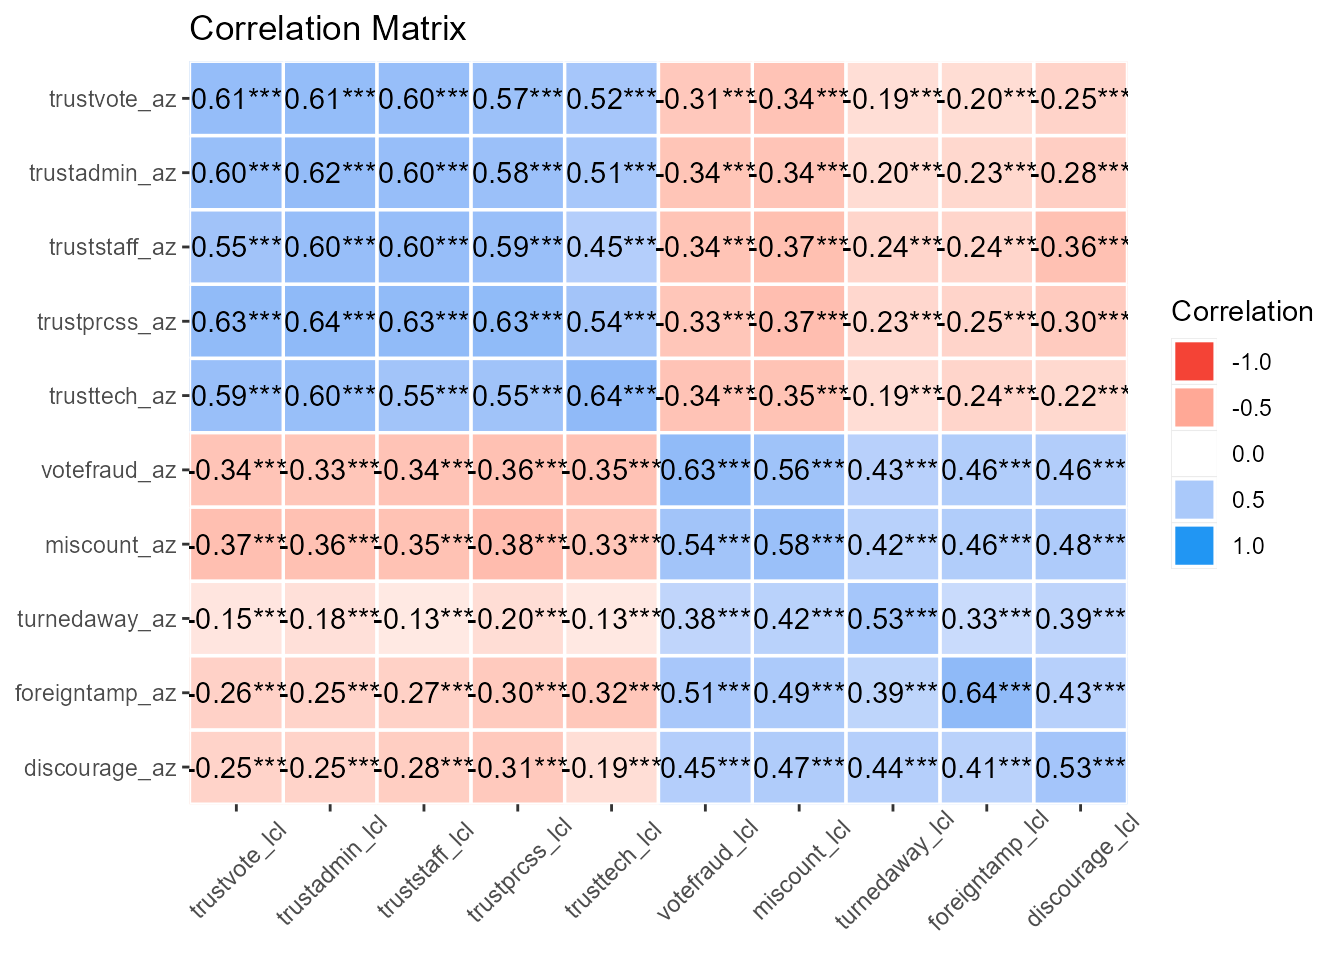

In [ ]:
# Get polychoric item correlation matrix.
item.cor <- data |>
  select(q19:q24, -q23, q28_1:q28_5, q30:q35, -q34, q40_1:q40_5) |> 
  # ensure factors are ordered factors
  mutate(across(where(is.factor), ~factor(., ordered = T))) |> 
  # adjust variable column names of items
  dplyr::rename(
    trustvote_az     = q19,
    trustadmin_az    = q20,
    truststaff_az    = q21,
    trustprcss_az    = q22,
    trusttech_az     = q24,
    votefraud_az     = q28_1,
    miscount_az      = q28_2,
    turnedaway_az    = q28_3,
    foreigntamp_az   = q28_4,
    discourage_az    = q28_5,
    trustvote_lcl    = q30,
    trustadmin_lcl   = q31,
    truststaff_lcl   = q32,
    trustprcss_lcl   = q33,
    trusttech_lcl    = q35,
    votefraud_lcl    = q40_1,
    miscount_lcl     = q40_2,
    turnedaway_lcl   = q40_3,
    foreigntamp_lcl  = q40_4,
    discourage_lcl   = q40_5
  ) |> 
  correlation::correlation(
    select = 
      c("trustvote_az", "trustadmin_az", "truststaff_az", "trustprcss_az", "trusttech_az",
        "votefraud_az", "miscount_az", "turnedaway_az", "foreigntamp_az", "discourage_az"),
    select2 =
      c("trustvote_lcl", "trustadmin_lcl", "truststaff_lcl", "trustprcss_lcl","trusttech_lcl",
        "votefraud_lcl", "miscount_lcl", "turnedaway_lcl", "foreigntamp_lcl","discourage_lcl"),
    method = "polychoric") |>
  summary()

# plot item correlations
plot(item.cor) + theme(axis.text.x = element_text(angle = 45, vjust = 0.6))

Indeed, this is what is revealed by the correlation matrix (@fig-polycor). Trust items correlate positively, strongly, and are significant regardless of location at which the items pertain. The same goes for distrust items. Also, items meant to measure trust negatively correlate with the items that measure distrust. However, the positive correlations are not nearly as high as would be expected supposing that the items are nearly identical theoretical indicators of the same hypothetical constructs, i.e., trust and distrust respectively.

If the items accurately measure trust/distrust in elections regardless of where those elections are said to take place, then positive correlations between the AZ and Local area items should approach perfect correlation as though the same exact questions were asked twice. This result, however, suggests that the location of which the survey items pertain (and perhaps other factors) makes a substantial difference in the pattern of responses, but also raises valid questions as to whether the items accurately measure the latent variable constructs in the first place.

Although I do not explicitly assume that the survey instruments perfectly measure the hypothetical constructs of interest (i.e., trust and distrust), perfect measurement is implicitly assumed by the method of combining multiple item responses into a sum or mean composite score.

In short, I expected item responses from the trust and distrust scales to be inversely correlated among the sample, but not mutually exclusive. Indeed, this is what I find. Polychoric correlations between the trust and distrust items negatively correlate as expected, as does the correlation between the two sum score scales. Given the ordinal nature of the variable items, I conducted a Spearman’s rank correlation test \[@spearman1907\] and found a negative correlation of $\rho = -0.49$ ($95\%$ CI \[-0.53, -0.44\]; Kendall’s $\tau = -0.39$) between scores on the two scales for the AZ items (For the local item scale score correlation: $\rho = -0.52$, $95\%$ CI \[-0.56, -0.48\]; Kendall’s $\tau = -0.39$). The negative correlation between the trust and distrust items and scores makes intuitive sense.



# Appendix E: Predicted Probabilities of Safety Concerns by Treatment Condition

In [ ]:
# save models to a list
safety_models <- list(
  "Concerns for Violence (OR)" = m.q25,
  "Confidence in Voter Safety (OR)" = m.q26)

cm <- c("conditionTreatment" = "Treatment",
        "Very concerned|Somewhat concerned" = "Very concerned | Somewhat concerned",
        "Somewhat concerned|Not too concerned" = "Somewhat concerned | Not too concerned",
        "Not too concerned|Not at all concerned" = "Not too concerned | Not at all concerned",
        "Not at all confident|Not too confident" = "Not at all confident | Not too confident",
        "Not too confident|Somewhat confident" = "Not too confident | Somewhat confident",
        "Somewhat confident|Very confident" = "Somewhat confident | Very confident"
        )

tbl_safety_logit <- modelsummary::modelsummary(
  safety_models,  
  fmt = 3,
  output = "tinytable",
  exponentiate = T, # show odds ratio 
  # coef_omit = c(-4), # only the beta coef, not the intercepts
  # coef_rename = c("conditionTreatment" = "Treatment"),
  coef_map = cm,
  stars = F,
  estimate = c("{estimate}, [{conf.low}, {conf.high}]"),
  statistic = NULL, 
  gof_map = c("nobs", "rmse"),
  note = "Parameter estimate (and confidence intervals) exponentiated to show odds ratios.",
  width = c(2, 1, 1)
  )

tbl_safety_logit |> 
  tinytable::style_tt(
    fontsize = 0.65 # fontsize of text in table in em units (0.75*default)
    ) |> 
  tinytable::style_tt(i = "notes", fontsize = 0.65, align = "l")

<!-- preamble start -->

 <!-- tinytable mathjax start -->
 
 
 <!-- tinytable mathjax end -->

 

 
 
 
 
 
 
 
 Concerns for Violence (OR) 
 Confidence in Voter Safety (OR) 
 
 
 Parameter estimate (and confidence intervals) exponentiated to show odds ratios. 
 
 
 Treatment 
 1.289, [1.055, 1.576] 
 1.494, [1.211, 1.844] 
 
 
 Very concerned | Somewhat concerned 
 0.153, [0.127, 0.186] 
 
 
 
 Somewhat concerned | Not too concerned 
 1.125, [0.969, 1.305] 
 
 
 
 Not too concerned | Not at all concerned 
 6.762, [5.595, 8.171] 
 
 
 
 Not at all confident | Not too confident 
 
 0.055, [0.041, 0.073] 
 
 
 Not too confident | Somewhat confident 
 
 0.280, [0.237, 0.332] 
 
 
 Somewhat confident | Very confident 
 
 3.150, [2.667, 3.721] 
 
 
 Num.Obs. 
 1286 
 1285 
 
 
 RMSE 
 2.44 
 2.91 
 
 
 
 
<!-- hack to avoid NA insertion in last line -->

In [ ]:
# table that shows the predicted probability of selecting a response or lower
# conditional to the Treatment experiment condition.
tab_safety_preds1 <- q25_preds |>  
  dplyr::as_tibble() |> 
  dplyr::mutate('Pr(>|z|)' = dplyr::case_when(
    p.value < 0.05 ~ '<0.05',
    p.value < 0.01 ~ '<0.01',
    .default = as.character(p.value)
  )) |> 
  select(group, condition, 
         estimate, std.error, statistic, 'Pr(>|z|)',
         conf.low, conf.high) |> 
  dplyr::rename(
    Condition = condition,
    Violence = group,
    z = statistic) |>
  insight::format_table(digits = 3)


tinytable::tt(
  tab_safety_preds1, digits = 3,
  notes = attr(data$q25, "label")) |> 
  tinytable::style_tt(
    fontsize = 0.65, # fontsize of text in table in em units (0.75*default)
    align = "llccccc") |> 
  tinytable::style_tt(i = "notes", fontsize = 0.65, align = "l")

<!-- preamble start -->

 <!-- tinytable mathjax start -->
 
 
 <!-- tinytable mathjax end -->

 

 
 
 
 
 
 
 Violence 
 Condition 
 estimate 
 std.error 
 z 
 Pr(>|z|) 
 conf.int 
 
 
 Thinking about Maricopa County, AZ, how concerned should voters feel about potential violence, threats of violence, or intimidation while voting in person at their local polling place? 
 
 
 Very concerned 
 Control 
 0.133 
 0.011 
 11.746 
 <0.05 
 [0.111, 0.155] 
 
 
 Very concerned 
 Treatment 
 0.106 
 0.010 
 10.977 
 <0.05 
 [0.087, 0.125] 
 
 
 Somewhat concerned 
 Control 
 0.396 
 0.016 
 25.430 
 <0.05 
 [0.366, 0.427] 
 
 
 Somewhat concerned 
 Treatment 
 0.360 
 0.015 
 23.556 
 <0.05 
 [0.330, 0.389] 
 
 
 Not too concerned 
 Control 
 0.342 
 0.015 
 23.296 
 <0.05 
 [0.313, 0.371] 
 
 
 Not too concerned 
 Treatment 
 0.374 
 0.015 
 24.825 
 <0.05 
 [0.344, 0.403] 
 
 
 Not at all concerned 
 Control 
 0.129 
 0.011 
 11.895 
 <0.05 
 [0.108, 0.150] 
 
 
 Not at all concerned 
 Treatment 
 0.160 
 0.012 
 12.882 
 <0.05 
 [0.136, 0.185] 
 
 
 
 
<!-- hack to avoid NA insertion in last line -->

In [ ]:
# table that shows the predicted probability of selecting a response or lower
# conditional to the Treatment experiment condition.
tab_safety_preds2 <- q26_preds |> 
  dplyr::as_tibble() |> 
  dplyr::mutate('Pr(>|z|)' = dplyr::case_when(
    p.value < 0.05 ~ '<0.05',
    p.value < 0.01 ~ '<0.01',
    .default = as.character(p.value)
  )) |> 
  select(group, condition, 
         estimate, std.error, statistic, 'Pr(>|z|)',
         conf.low, conf.high) |> 
  dplyr::rename(
    Condition = condition,
    'Voter Safety' = group,
    z = statistic) |>
  insight::format_table(digits = 3)

tinytable::tt(
  tab_safety_preds2, digits = 3,
  notes = attr(data$q26, "label")) |>  
  tinytable::style_tt(
    fontsize = 0.65, # fontsize of text in table in em units (0.75*default)
    align = "llccccc"
    ) |> 
  tinytable::style_tt(i = "notes", fontsize = 0.65)

<!-- preamble start -->

 <!-- tinytable mathjax start -->
 
 
 <!-- tinytable mathjax end -->

 

 
 
 
 
 
 
 Voter Safety 
 Condition 
 estimate 
 std.error 
 z 
 Pr(>|z|) 
 conf.int 
 
 
 How confident, if at all, are you that in person polling places in Maricopa County, AZ will be safe places for voters to cast their ballots during the upcoming elections in November? 
 
 
 Not at all confident 
 Control 
 0.052 
 0.007 
 7.302 
 <0.05 
 [0.038, 0.066] 
 
 
 Not at all confident 
 Treatment 
 0.035 
 0.005 
 6.932 
 <0.05 
 [0.025, 0.045] 
 
 
 Not too confident 
 Control 
 0.167 
 0.013 
 13.268 
 <0.05 
 [0.142, 0.192] 
 
 
 Not too confident 
 Treatment 
 0.123 
 0.010 
 11.924 
 <0.05 
 [0.102, 0.143] 
 
 
 Somewhat confident 
 Control 
 0.540 
 0.014 
 38.037 
 <0.05 
 [0.512, 0.568] 
 
 
 Somewhat confident 
 Treatment 
 0.520 
 0.014 
 36.134 
 <0.05 
 [0.492, 0.549] 
 
 
 Very confident 
 Control 
 0.241 
 0.016 
 15.519 
 <0.05 
 [0.211, 0.271] 
 
 
 Very confident 
 Treatment 
 0.322 
 0.017 
 18.550 
 <0.05 
 [0.288, 0.356] 
 
 
 
 
<!-- hack to avoid NA insertion in last line -->